In [594]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

from scipy.stats import spearmanr, mannwhitneyu, kruskal

from matplotlib.ticker import FuncFormatter, MultipleLocator
from matplotlib import rcParams

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'


**Auxiliary Functions**

In [595]:
def read_csv(fpath): 
    return pd.read_csv(fpath,sep='\t',header=0,index_col=0)

def subsetDf(df,criteria):
    '''
    Retains only rows in a pandas.DataFrame that match select criteria. 

    Args:
        df (pandas.DataFrame)
        criteria (dictionary): keys (str) are column headers in df, and values (list) are respective column values

    Returns (pandas.DataFrame)
    '''

    if criteria is None: return df

    # if a criteria (dictionary) has a value that is not list format, put it into a list
    for key,value in criteria.items():
        if not isinstance(value,list):
            criteria[key] = [value]

    return df[df.isin(criteria).sum(1)==len(criteria)]

def largeTickLabels(ax,fontsize=20):
    [ii.set(fontsize=fontsize) for ii in ax.get_xticklabels()+ax.get_yticklabels()]

def thicken_spines(ax,lw=4): [ii.set(lw=lw) for _,ii in ax.spines.items()]

def reformat_thousands_ticks(tick_val,tick_pos):
    tick_val = round(tick_val/1000,1)
    return '{:.0f}K'.format(tick_val)

## Initialize Working Space

In [596]:
ParentPath = '/Users/firasmidani/Box_Duke/project_davidlab/LAD_LAB_Personnel/Firas/'
ParentPath+= 'FIRAS_EXPERIMENTS/_2022_03_31_bacteroides_data_analysis'

In [597]:
!echo "Location of Notebook"
!pwd
!echo
!echo "Contents of Working Directory"
!ls $ParentPath

Location of Notebook
/Users/firasmidani/Box_Duke/project_davidlab/LAD_LAB_Personnel/Firas/FIRAS_EXPERIMENTS/_2022_03_31_bacteroides_data_analysis/notebooks

Contents of Working Directory
README.txt data       mapping    notebooks
counts     figures    models     tables


In [598]:
dict_substrate_group = {'Water':'Water','Rich_Media':'Rich Media',
                        'Monosaccharide':'Simple Sugars','Disaccharide':'Simple Sugars',
                        'Polysaccharide':'Complex Sugars','Oligosaccharide':None}

substrate_descriptions = read_csv(ParentPath + '/mapping/substrate_descriptions.txt')
substrate_descriptions.loc[:,'Substrate_Group'] = substrate_descriptions.apply(lambda x: dict_substrate_group[x['Substrate_Type']],axis=1)
print(substrate_descriptions.shape)

dict_substrate_label = substrate_descriptions.to_dict()['Substrate_Label']
dict_species_colors = {'BO':'navy','BF':'tomato','BT':'mediumseagreen','BV':'orange'}
dict_species_labels = {'BO':'B. ovatus','BF':'B. fragilis','BT':'B. theta','BV':'B. vulgatus'}
dict_species_small_labels = {'BO':'Bo','BF':'Bf','BT':'Bt','BV':'Bv'}

color_df = pd.DataFrame(dict_species_colors,index=['Color']).T

(34, 3)


## Prepare Meta-Data

**Import Meta-Data**

In [599]:
mapping = read_csv(ParentPath + '/mapping/mapping.txt')

print('There are {} samples with {} data columns.'.format(mapping.shape[0],mapping.shape[1]))

There are 1832 samples with 15 data columns.


**Remove Starch (Wheat) Samples**

In [600]:
to_remove = [ii for ii in mapping.Substrate if 'Wheat' in ii]
mapping = mapping.loc[~mapping.Substrate.isin(to_remove),:]
print(mapping.shape)

(1652, 15)


**Remove Sucrose Baseline Samples**

In [601]:
to_remove = subsetDf(mapping,{'Substrate':'Sucrose','TimePoint':0}).index
mapping = mapping.drop(to_remove)
print(mapping.shape)

(1620, 15)


## Tabulate Sample Counts

**Add Counts**

In [602]:
ls_df_counts = []

# I infer cellular counts on a server managed by SLURM. 
# Analysis was split into 18 parallel jobs, where each jobs is a chunk of about 100 jobs.
for ii in range(0,19):
    filepath = ParentPath + '/counts/EventsCount-InferComponents-{}.txt'.format(ii)
    df_counts = pd.read_csv(filepath,sep='\t',header=0,index_col=0).dropna()
    ls_df_counts.append(df_counts)
    
df_counts = pd.concat(ls_df_counts)
mapping = mapping.join(df_counts)

print(df_counts.shape)
df_counts.head()

(1832, 1)


,EventsCount
Filename,
FSM2018-07-26.0004.fcs,56032.0
FSM2018-07-26.0005.fcs,64363.0
FSM2018-07-26.0006.fcs,211.0
FSM2018-07-26.0007.fcs,63.0
FSM2018-07-26.0008.fcs,60.0


## Infer Species Identity for All Clusters

### Import Table of Clusters
This the output of GMM models that infer all clusters in each samples.

In [603]:
def get_all_clusters(mapping,condition):

    cond_clusters = []
    
    for sp in ['BO','BF','BT','BV','MIX']:
    
        condition['Species'] = sp
        cond_sp_sample = subsetDf(mapping,condition)
        if cond_sp_sample.shape[0] == 0: continue 
        cond_sp_sample = cond_sp_sample.index.values[0]
        
        read_csv_kws = {'sep':'\t','header':0,'index_col':0}
        cond_model = ParentPath + '/models/' + cond_sp_sample + '.txt'
        cond_model = pd.read_csv(cond_model, **read_csv_kws)
        cond_model.loc[:,'Species'] = [sp]*cond_model.shape[0]
        cond_clusters.append(cond_model)
        
    cond_clusters = pd.concat(cond_clusters).reset_index(drop=True)
    
    return cond_clusters

In [604]:
unique_conditions = mapping[mapping.Species=='MIX']
unique_conditions = unique_conditions.loc[:,['Substrate','TimePoint','Rep']].drop_duplicates()

ls_df = []

for idx,unique_cond in unique_conditions.iterrows():
    
    #print('Condition\t\t',unique_cond.to_dict())
    
    df_clusters = get_all_clusters(mapping,unique_cond.to_dict())
    
    unique_cond_df = pd.DataFrame([unique_cond.values]*df_clusters.shape[0])
    unique_cond_df.columns = ['Substrate','TimePoint','Rep']

    ls_df.append(unique_cond_df.join(df_clusters))
    
df = pd.concat(ls_df)
df = df.reset_index(drop=True)

### Add Counts
For each cluster of events (row), include the count of events (which allows us to compute absolute abundance of the cluster. 

In [605]:
ls_foo = []
ls_mix = []
for idx,row in df.iterrows():
    foo = subsetDf(mapping,{'Substrate':row['Substrate'],
                    'TimePoint':row['TimePoint'],
                    'Rep':row['Rep'],
                    'Species':row['Species']}).EventsCount.values
    
    if len(foo)>0: ls_foo.append(foo[0])
    else: ls_foo.append(np.nan)
        
    mix = subsetDf(mapping,{'Substrate':row['Substrate'],
                    'TimePoint':row['TimePoint'],
                    'Rep':row['Rep'],
                    'Species':'MIX'
                    }).EventsCount.values
    
    if len(mix)>0: ls_mix.append(mix[0])
    else: ls_mix.append(np.nan)
        
foo = pd.DataFrame(ls_foo,index=df.index.values,columns=['SpeciesCount'])
mix = pd.DataFrame(ls_mix,index=df.index.values,columns=['MixCount'])

In [606]:
df = df.join(foo).join(mix)
df.head()

,Substrate,TimePoint,Rep,SYTO-H,RFP-H,GFP-H,SSC-H,FSC-H,Weight,Species,SpeciesCount,MixCount
0,FOS_Chicory,102,1.0,709.445865,451.717833,421.983043,461.198015,290.954946,0.710362,BO,56032.0,74765.0
1,FOS_Chicory,102,1.0,673.745776,457.555692,417.841903,358.575312,293.913771,0.289638,BO,56032.0,74765.0
2,FOS_Chicory,102,1.0,715.736100,707.365885,434.964750,511.339817,306.096975,0.954185,BF,74493.0,74765.0
3,FOS_Chicory,102,1.0,740.371050,720.623633,441.038650,427.561911,397.453830,0.045815,BF,74493.0,74765.0
4,FOS_Chicory,102,1.0,684.102143,454.913824,681.929756,399.105304,303.280536,0.368295,BT,70493.0,74765.0


In [607]:
#df.to_csv('./tables/mono_and_mix_clusters.txt',sep='\t',header=True,index=True)

### Train Model on Monocultures

In [608]:
def get_confusion_matrix(df):
    '''Return confusion matrix from data frame with actual and predicted labels'''

    y_true = df.Species.values
    y_pred = df.Prediction.values

    df_cf = pd.DataFrame(confusion_matrix(y_true,y_pred),index=species,columns=species)
    
    return df_cf

def count_confusion_errors(confusion_matrix,report=False):
    '''Compute number and proportion of errors from confusion matrix'''
    nsamples = confusion_matrix.sum().sum()
    nsamples_correct = np.diag(confusion_matrix).sum()
    nsamples_wrong = nsamples - nsamples_correct
    psamples_wrong = float(nsamples_wrong)/nsamples
    
    if report:
        msg = 'There are a total {} '.format(nsamples_wrong)
        msg+= 'which account for ({:.2f}%) errors'.format(psamples_wrong)
        print(msg)
        
    return nsamples_wrong, psamples_wrong

#### Prepare Data for Training

In [609]:
data = df.copy()
data = subsetDf(data,{'Species':['BO','BF','BT','BV']})
data = data.replace({'Species':{'BO':1,'BF':2,'BT':3,'BV':4}})
data = data.reset_index(drop=True)
data.head()

,Substrate,TimePoint,Rep,SYTO-H,RFP-H,GFP-H,SSC-H,FSC-H,Weight,Species,SpeciesCount,MixCount
0,FOS_Chicory,102,1.0,709.445865,451.717833,421.983043,461.198015,290.954946,0.710362,1,56032.0,74765.0
1,FOS_Chicory,102,1.0,673.745776,457.555692,417.841903,358.575312,293.913771,0.289638,1,56032.0,74765.0
2,FOS_Chicory,102,1.0,715.736100,707.365885,434.964750,511.339817,306.096975,0.954185,2,74493.0,74765.0
3,FOS_Chicory,102,1.0,740.371050,720.623633,441.038650,427.561911,397.453830,0.045815,2,74493.0,74765.0
4,FOS_Chicory,102,1.0,684.102143,454.913824,681.929756,399.105304,303.280536,0.368295,3,70493.0,74765.0


In [610]:
model_data = data.copy()

#### Test Model without Cross Validation

**Training**

In [611]:
varbs = ['RFP-H','GFP-H','SYTO-H','SSC-H','FSC-H']
species = ['BO','BF','BT','BV']

X = model_data.loc[:,varbs].values
y = model_data.loc[:,'Species'].values

clf = RandomForestClassifier(n_estimators=1000,oob_score=True)
clf_fit = clf.fit(X,y)

print('Out-of-bag score is {:.3f}'.format(clf_fit.oob_score_))

Out-of-bag score is 0.949


In [612]:
result = permutation_importance(clf_fit, X, y, n_repeats=10,random_state=0)
df_importance = pd.DataFrame(index=varbs,columns=['Mean','Std'])
df_importance['Mean'] = result['importances_mean']
df_importance['Std'] = result['importances_std']
df_importance = df_importance.sort_values(['Mean'],ascending=True)

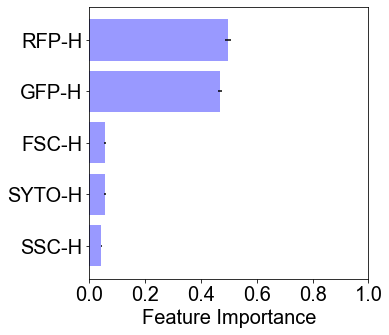

In [613]:
fig,ax = plt.subplots(figsize=[5,5])

ax.barh(y=np.arange(0,5), width = df_importance.Mean,xerr=df_importance.Std,
        color=(0.5,0.5,1,0.8))

plt.setp(ax,yticks=np.arange(0,5),yticklabels=df_importance.index.values)

largeTickLabels(ax,fontsize=20)

ax.set_xlabel('Feature Importance',fontsize=20)

ax.set_xlim([0,1.0])

plt.savefig(ParentPath + '/figures/model_feature_importances_permutation_based.pdf',bbox_inches='tight')

**Testing (definitely overfitting)**

In [614]:
clf_pred = clf.predict(X)
clf_prob = clf.predict_proba(X)

df_clf_pred = pd.DataFrame(clf_pred,columns=['Prediction'],index=model_data.index.values)
df_clf_prob = pd.DataFrame(clf_prob,columns=['p_'+ii for ii in species],index=model_data.index.values)
model_data = model_data.join(df_clf_pred).join(df_clf_prob)
model_data.head()

,Substrate,TimePoint,Rep,SYTO-H,RFP-H,GFP-H,SSC-H,FSC-H,Weight,Species,SpeciesCount,MixCount,Prediction,p_BO,p_BF,p_BT,p_BV
0,FOS_Chicory,102,1.0,709.445865,451.717833,421.983043,461.198015,290.954946,0.710362,1,56032.0,74765.0,1,0.993,0.000,0.005,0.002
1,FOS_Chicory,102,1.0,673.745776,457.555692,417.841903,358.575312,293.913771,0.289638,1,56032.0,74765.0,1,0.991,0.000,0.003,0.006
2,FOS_Chicory,102,1.0,715.736100,707.365885,434.964750,511.339817,306.096975,0.954185,2,74493.0,74765.0,2,0.001,0.998,0.000,0.001
3,FOS_Chicory,102,1.0,740.371050,720.623633,441.038650,427.561911,397.453830,0.045815,2,74493.0,74765.0,2,0.000,0.993,0.000,0.007
4,FOS_Chicory,102,1.0,684.102143,454.913824,681.929756,399.105304,303.280536,0.368295,3,70493.0,74765.0,3,0.006,0.000,0.990,0.004


#### Test Model with 50-50 split (by replicates)

In [ ]:
model_data = data.copy()

model_data_train = subsetDf(model_data,{'Rep':1})
model_data_test = subsetDf(model_data,{'Rep':2})

model_data_train.shape, model_data_test.shape

**Training**

In [ ]:
varbs = ['RFP-H','GFP-H','SYTO-H','SSC-H','FSC-H']
species = ['BO','BF','BT','BV']

X_train = model_data_train.loc[:,varbs].values
y_train = model_data_train.loc[:,'Species'].values

clf = RandomForestClassifier(n_estimators=1000,oob_score=True)
clf_fit = clf.fit(X_train,y_train)

print('Out-of-bag score is {:.3f}'.format(clf_fit.oob_score_))

**Testing**

In [ ]:
X_test = model_data_test.loc[:,varbs].values
y_test = model_data_test.loc[:,'Species'].values

clf_pred = clf.predict(X_test)
clf_prob = clf.predict_proba(X_test)

df_clf_pred = pd.DataFrame(clf_pred,columns=['Prediction'],index=model_data_test.index.values)
df_clf_prob = pd.DataFrame(clf_prob,columns=['p_'+ii for ii in species],index=model_data_test.index.values)
model_data_test = model_data_test.join(df_clf_pred).join(df_clf_prob)
model_data_test.head()

**Confirm Species Labels**

In [ ]:
model_data_train = model_data_train.copy().replace(
                    {'Species':{1:'BO',2:'BF',3:'BT',4:'BV'},
                     'Prediction':{1:'BO',2:'BF',3:'BT',4:'BV'}})
model_data_test = model_data_test.copy().replace(
                    {'Species':{1:'BO',2:'BF',3:'BT',4:'BV'},
                     'Prediction':{1:'BO',2:'BF',3:'BT',4:'BV'}})


**Save Random Forest Predictions of Species Identity for all Clusters**

In [ ]:
model_data_test.to_csv(ParentPath + '/tables/random_forest_cluster_predictions_mono.txt',sep='\t',header=True,index=True)

**Estimate Model Performance**

In [592]:
model_data_test.shape

(80, 12)

In [593]:
df_cf = get_confusion_matrix(model_data_test)
count_confusion_errors(df_cf,report=True)

AttributeError: 'DataFrame' object has no attribute 'Prediction'

### Error Analysis

* Which samples seem to have errors? 
* Does it hint at when misclassification typically occur? 
* Is misclassification something we need to worry about or acceptable errror?

**Let's first look at breakdown of erros**

In [320]:
corrects = model_data_test[model_data_test.Species==model_data_test.Prediction]
errors = model_data_test[model_data_test.Species!=model_data_test.Prediction]
print(corrects.shape,errors.shape)
errors.head()

(1063, 17) (70, 17)


,Substrate,TimePoint,Rep,SYTO-H,RFP-H,GFP-H,SSC-H,FSC-H,Weight,Species,SpeciesCount,MixCount,Prediction,p_BO,p_BF,p_BT,p_BV
122,Chitin,102,2.0,615.714185,547.993727,586.172134,907.083600,876.144344,0.671673,BO,311.0,136.0,BV,0.024,0.219,0.085,0.672
124,Chitin,102,2.0,653.870014,583.007276,602.789541,919.682184,882.993765,0.405830,BF,267.0,136.0,BV,0.018,0.297,0.103,0.582
126,Chitin,102,2.0,604.616685,538.208756,575.196700,864.208336,807.884969,0.157380,BT,838.0,136.0,BV,0.080,0.146,0.177,0.597
141,Pectin_Citrus,102,2.0,675.757293,496.965031,456.766934,619.760038,346.978654,0.048236,BO,47385.0,65807.0,BV,0.334,0.249,0.050,0.367
145,Pectin_Citrus,102,2.0,651.841842,493.137126,728.139254,456.003092,359.286400,0.054854,BT,68457.0,65807.0,BV,0.015,0.002,0.435,0.548


**Use below data to manually craft Supplementary Figure 2B in Microsoft PowerPoint**

Baseline distributions of species and time points for testing data set

In [321]:
model_data_test.Species.value_counts()

BV    420
BT    241
BO    240
BF    232
Name: Species, dtype: int64

In [322]:
model_data_test.Species.value_counts()/model_data_test.shape[0]

BV    0.370697
BT    0.212710
BO    0.211827
BF    0.204766
Name: Species, dtype: float64

In [323]:
model_data_test.TimePoint.value_counts()

48     329
24     320
102    308
72     176
Name: TimePoint, dtype: int64

In [324]:
model_data_test.TimePoint.value_counts()/model_data_test.shape[0]

48     0.290380
24     0.282436
102    0.271845
72     0.155340
Name: TimePoint, dtype: float64

Number of errors based on correct and incorrect label. There are four species, so there are 12 possible types of labelling errors.

In [325]:
species = ['BO','BF','BT','BV']
tmp = errors.loc[:,['Substrate','TimePoint','Species','Prediction']+['p_'+ii for ii in species]]

error_map = tmp.loc[:,['Species','Prediction']].value_counts()
error_map

Species  Prediction
BV       BO            14
         BF            10
BO       BF             9
BT       BV             9
BV       BT             7
BO       BV             6
BT       BO             6
BF       BO             3
         BV             3
         BT             1
BO       BT             1
BT       BF             1
dtype: int64

Number of errors based on true species label.

#### Effect of sample cell count on model performance

**How does the model improve if we remove samples with low abundances?** Let's try a learning curve.

In [573]:
model_data = data.copy()

ls_sc_oob = []
ls_sc_size = []

for sc in np.linspace(0,100000,101):
    
    model_data = model_data[model_data.SpeciesCount>sc]

    model_data_train = subsetDf(model_data,{'Rep':1})
    model_data_test = subsetDf(model_data,{'Rep':2})

    model_data_train.shape, model_data_test.shape
    
    ## training
    varbs = ['RFP-H','GFP-H','SYTO-H','SSC-H','FSC-H']
    species = ['BO','BF','BT','BV']

    X_train = model_data_train.loc[:,varbs].values
    y_train = model_data_train.loc[:,'Species'].values

    clf = RandomForestClassifier(n_estimators=1000,oob_score=True)
    clf_fit = clf.fit(X_train,y_train)

    #print('Species Count Trheshold:',sc)
    #print('Out-of-bag score is {:.3f}'.format(clf_fit.oob_score_))
    
    ls_sc_oob.append([sc,clf_fit.oob_score_])
    ls_sc_size.append([sc,model_data.shape[0]])

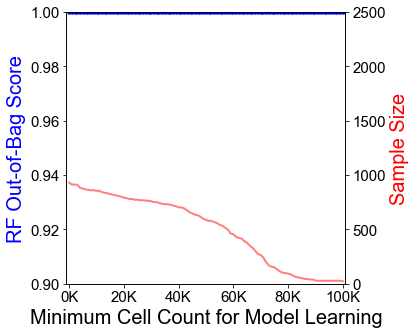

In [577]:
df_sc_oob = pd.DataFrame(ls_sc_oob,columns=['Threshold','OOB'])
df_sc_size = pd.DataFrame(ls_sc_size,columns=['Threshold','N'])

fig,ax = plt.subplots(figsize=[5,5])

ax.scatter(df_sc_oob['Threshold'],df_sc_oob['OOB'],s=20,color=(0,0,1,1),lw=0,zorder=2)
ax.plot(df_sc_oob['Threshold'],df_sc_oob['OOB'],lw=2,color=(0,0,1,0.5),zorder=1)

axt = ax.twinx()

axt.plot(df_sc_size['Threshold'],df_sc_size['N'],lw=2,color=(1,0,0,0.5),zorder=1)

ax.set_xlim([-1000,101000])
ax.xaxis.set_major_formatter(FuncFormatter(reformat_thousands_ticks))

ax.set_ylim([0.90,1.00])
axt.set_ylim([0,2500])

largeTickLabels(ax,fontsize=15)
largeTickLabels(axt,fontsize=15)

xl1 = ax.set_xlabel('Minimum Cell Count for Model Learning',fontsize=20)

yl1 = ax.set_ylabel('RF Out-of-Bag Score',fontsize=20,color='Blue')
yl2 = axt.set_ylabel('Sample Size',rotation=90,fontsize=20,color='Red')

plt.savefig(ParentPath + '/figures/effect_cell_count_model_learning.pdf',bbox_inches='tight')

#### Effect of cluster weights on model performance
How does filtering by cluster weight affect model performance?

In [578]:
model_data = data.copy()

ls_sc_oob = []
ls_sc_size = []

for sc in np.linspace(0,0.5,26):
    
    model_data = model_data[model_data.Weight>sc]

    model_data_train = subsetDf(model_data,{'Rep':1})
    model_data_test = subsetDf(model_data,{'Rep':2})

    model_data_train.shape, model_data_test.shape
    
    ## training
    varbs = ['RFP-H','GFP-H','SYTO-H','SSC-H','FSC-H']
    species = ['BO','BF','BT','BV']

    X_train = model_data_train.loc[:,varbs].values
    y_train = model_data_train.loc[:,'Species'].values

    clf = RandomForestClassifier(n_estimators=1000,oob_score=True)
    clf_fit = clf.fit(X_train,y_train)

    #print('Species Count Trheshold:',sc)
    #print('Out-of-bag score is {:.3f}'.format(clf_fit.oob_score_))
    
    ls_sc_oob.append([sc,clf_fit.oob_score_])
    ls_sc_size.append([sc,model_data.shape[0]])

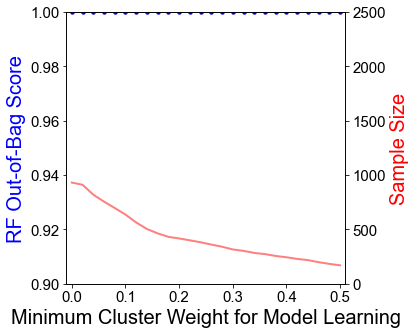

In [579]:
df_sc_oob = pd.DataFrame(ls_sc_oob,columns=['Threshold','OOB'])
df_sc_size = pd.DataFrame(ls_sc_size,columns=['Threshold','N'])

fig,ax = plt.subplots(figsize=[5,5])

ax.scatter(df_sc_oob['Threshold'],df_sc_oob['OOB'],s=20,color=(0,0,1,1),lw=0,zorder=2)
ax.plot(df_sc_oob['Threshold'],df_sc_oob['OOB'],lw=2,color=(0,0,1,0.5),zorder=1)

axt = ax.twinx()

axt.plot(df_sc_size['Threshold'],df_sc_size['N'],lw=2,color=(1,0,0,0.5),zorder=1)

ax.set_xlim([-0.01,0.51])
ax.set_ylim([0.90,1.00])
axt.set_ylim([0,2500])

largeTickLabels(ax,fontsize=15)
largeTickLabels(axt,fontsize=15)

xl1 = ax.set_xlabel('Minimum Cluster Weight for Model Learning',fontsize=20)

yl1 = ax.set_ylabel('RF Out-of-Bag Score',fontsize=20,color='Blue')
yl2 = axt.set_ylabel('Sample Size',rotation=90,fontsize=20,color='Red')

plt.savefig(ParentPath + '/figures/effect_cluster_weight_model_learning.pdf', bbox_inches='tight')

#### Plot differences between corrent and incorrect predictions

In [326]:
a_correct_probs = corrects.apply(lambda x: x['p_'+str(x['Prediction'])],axis=1).values
a_error_probs = errors.apply(lambda x: x['p_'+str(x['Prediction'])],axis=1).values


to_store = [np.median(a_error_probs),
            np.median(a_correct_probs),
            np.median(errors.Weight.values),
            np.median(corrects.Weight.values),
            np.std(a_error_probs),
            np.std(a_correct_probs),
            np.std(errors.Weight.values),
            np.std(corrects.Weight.values)]

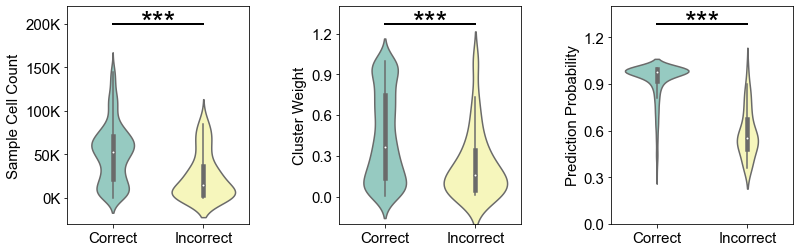

In [327]:
from seaborn import violinplot

fig,axes = plt.subplots(1,3,figsize=[13,4])

tmp_correct_probs = corrects.apply(lambda x: x['p_'+str(x['Prediction'])],axis=1).values
tmp_error_probs =errors.apply(lambda x: x['p_'+str(x['Prediction'])],axis=1).values

violin_kwargs = {'width':0.7,'zorder':1,'palette':'Set3'}
scatter_kwargs = {'s':0,'color':(0,0,0,0.1),'zorder':2}

ax = axes[0]

ax.scatter(np.random.normal(0,0.05,corrects.shape[0]),
           corrects.SpeciesCount.values,**scatter_kwargs)
ax.scatter(np.random.normal(1,0.05,errors.shape[0]),
           errors.SpeciesCount.values,**scatter_kwargs)

tmp1 = corrects.loc[:,['SpeciesCount']]
tmp2 = errors.loc[:,['SpeciesCount']]

tmp1['Outcome'] = 'Correct'
tmp2['Outcome'] = 'Incorrect'

tmp = pd.concat([tmp1,tmp2])

violinplot(x='Outcome',y='SpeciesCount',data=tmp,ax=ax,**violin_kwargs)

ax.set_ylim([-30000,220000])
ax.yaxis.set_major_locator(MultipleLocator(50000))
ax.yaxis.set_major_formatter(reformat_thousands_ticks)

largeTickLabels(ax,fontsize=15)
ax.set_ylabel('Sample Cell Count',fontsize=15)

ax = axes[1]

ax.scatter(np.random.normal(0,0.05,corrects.shape[0]),
           corrects.Weight.values,**scatter_kwargs)
ax.scatter(np.random.normal(1,0.05,errors.shape[0]),
           errors.Weight.values,**scatter_kwargs)

tmp1 = corrects.loc[:,['Weight']]
tmp2 = errors.loc[:,['Weight']]

tmp1['Outcome'] = 'Correct'
tmp2['Outcome'] = 'Incorrect'

tmp = pd.concat([tmp1,tmp2])

violinplot(x='Outcome',y='Weight',data=tmp,ax=ax,**violin_kwargs)

ax.set_ylim([-0.2,1.4])
largeTickLabels(ax,fontsize=15)
ax.set_ylabel('Cluster Weight',fontsize=15)
ax.yaxis.set_major_locator(MultipleLocator(0.3))

ax = axes[2]


tmp1 = pd.DataFrame([tmp_correct_probs,['Correct']*len(tmp_correct_probs)]).T
tmp2 = pd.DataFrame([tmp_error_probs,['Incorrect']*len(tmp_error_probs)]).T

tmp1.columns=['Probability','Outcome']
tmp2.columns=['Probability','Outcome']

tmp = pd.concat([tmp1,tmp2],axis=0)
tmp['Probability'] = tmp.Probability.astype(float)

ax.scatter(np.random.normal(0,0.05,tmp[tmp.Outcome=='Correct'].shape[0]),
           tmp[tmp.Outcome=='Correct'].Probability.values,
           **scatter_kwargs)
ax.scatter(np.random.normal(1,0.05,tmp[tmp.Outcome=='Incorrect'].shape[0]),
           tmp[tmp.Outcome=='Incorrect'].Probability.values,
           **scatter_kwargs)

violinplot(x='Outcome',y='Probability',data=tmp,ax=ax,**violin_kwargs)

ratio = 0.92

ax.set_ylim([0,1.4])
largeTickLabels(ax,fontsize=15)
ax.set_ylabel('Prediction Probability',fontsize=15)
ax.yaxis.set_major_locator(MultipleLocator(0.3))

ax = axes[0]
ylims = ax.get_ylim()[1]-ax.get_ylim()[0]
ybar = ylims*ratio + ax.get_ylim()[0]

ax.axhline(ybar,0.25,0.75,color='black',lw=2)
ax.text(0.5,0.985,'***',color='black',fontsize=30,transform=ax.transAxes,va='top',ha='center')

ax = axes[1]
ylims = ax.get_ylim()[1]-ax.get_ylim()[0]
ybar = ylims*ratio + ax.get_ylim()[0]

ax.axhline(ybar,0.25,0.75,color='black',lw=2)
ax.text(0.5,0.985,'***',color='black',fontsize=30,transform=ax.transAxes,va='top',ha='center')

ax = axes[2]
ylims = ax.get_ylim()[1]-ax.get_ylim()[0]
ybar = ylims*ratio + ax.get_ylim()[0]

ax.axhline(ybar,0.25,0.75,color='black',lw=2)
ax.text(0.5,0.985,'***',color='black',fontsize=30,transform=ax.transAxes,va='top',ha='center')

for ax in axes: ax.set_xlabel('')

plt.subplots_adjust(wspace=0.5)

plt.savefig(ParentPath + '/figures/violin_plots_errors.pdf',bbox_inches='tight')

### Apply Model to Cocultures

In [328]:
data = df.copy()
data = subsetDf(data,{'Species':['BO','BF','BT','BV']})
data = data.replace({'Species':{'BO':1,'BF':2,'BT':3,'BV':4}})
data = data.reset_index(drop=True)
data.head()

,Substrate,TimePoint,Rep,SYTO-H,RFP-H,GFP-H,SSC-H,FSC-H,Weight,Species,SpeciesCount,MixCount
0,FOS_Chicory,102,1.0,709.445865,451.717833,421.983043,461.198015,290.954946,0.710362,1,56032.0,74765.0
1,FOS_Chicory,102,1.0,673.745776,457.555692,417.841903,358.575312,293.913771,0.289638,1,56032.0,74765.0
2,FOS_Chicory,102,1.0,715.736100,707.365885,434.964750,511.339817,306.096975,0.954185,2,74493.0,74765.0
3,FOS_Chicory,102,1.0,740.371050,720.623633,441.038650,427.561911,397.453830,0.045815,2,74493.0,74765.0
4,FOS_Chicory,102,1.0,684.102143,454.913824,681.929756,399.105304,303.280536,0.368295,3,70493.0,74765.0


**Repeat prediction of monocultures again for quality control**

In [329]:
model_data = data.copy()

varbs = ['RFP-H','GFP-H','SYTO-H','SSC-H','FSC-H']
species = ['BO','BF','BT','BV']

X = model_data.loc[:,varbs].values
y = model_data.loc[:,'Species'].values

clf = RandomForestClassifier(n_estimators=1000,oob_score=True)
clf_fit = clf.fit(X,y)

print('Out-of-bag score is {:.3f}'.format(clf_fit.oob_score_))

Out-of-bag score is 0.948


**Now predict co-cultures**

In [330]:
data = df.copy()
data = subsetDf(data,{'Species':['MIX']})
data = data.reset_index(drop=True)
data.head()

,Substrate,TimePoint,Rep,SYTO-H,RFP-H,GFP-H,SSC-H,FSC-H,Weight,Species,SpeciesCount,MixCount
0,FOS_Chicory,102,1.0,688.763033,679.801191,456.442125,487.689015,301.263153,0.115445,MIX,74765.0,74765.0
1,FOS_Chicory,102,1.0,696.207778,681.901456,632.530859,501.375577,305.726306,0.793588,MIX,74765.0,74765.0
2,FOS_Chicory,102,1.0,743.060842,697.471673,647.491984,451.097294,394.686229,0.090967,MIX,74765.0,74765.0
3,Starch_Rice,102,1.0,738.149536,538.051973,558.534566,331.656985,644.815660,0.130989,MIX,76840.0,76840.0
4,Starch_Rice,102,1.0,741.771511,540.680917,568.478138,863.423806,899.715306,0.313782,MIX,76840.0,76840.0


In [331]:
X = data.loc[:,varbs].values

clf_pred = clf.predict(X)
clf_prob = clf.predict_proba(X)

df_clf_pred = pd.DataFrame(clf_pred,columns=['Prediction'],index=data.index.values)
df_clf_prob = pd.DataFrame(clf_prob,columns=['p_'+ii for ii in species],index=data.index.values)

model_data = data.join(df_clf_pred).join(df_clf_prob)

model_data = model_data.copy().replace({'Prediction':{1:'BO',2:'BF',3:'BT',4:'BV'}})

model_data.head()

,Substrate,TimePoint,Rep,SYTO-H,RFP-H,GFP-H,SSC-H,FSC-H,Weight,Species,SpeciesCount,MixCount,Prediction,p_BO,p_BF,p_BT,p_BV
0,FOS_Chicory,102,1.0,688.763033,679.801191,456.442125,487.689015,301.263153,0.115445,MIX,74765.0,74765.0,BF,0.003,0.789,0.002,0.206
1,FOS_Chicory,102,1.0,696.207778,681.901456,632.530859,501.375577,305.726306,0.793588,MIX,74765.0,74765.0,BV,0.001,0.051,0.005,0.943
2,FOS_Chicory,102,1.0,743.060842,697.471673,647.491984,451.097294,394.686229,0.090967,MIX,74765.0,74765.0,BV,0.000,0.024,0.005,0.971
3,Starch_Rice,102,1.0,738.149536,538.051973,558.534566,331.656985,644.815660,0.130989,MIX,76840.0,76840.0,BV,0.011,0.023,0.137,0.829
4,Starch_Rice,102,1.0,741.771511,540.680917,568.478138,863.423806,899.715306,0.313782,MIX,76840.0,76840.0,BV,0.106,0.276,0.135,0.483


In [332]:
model_data.to_csv(ParentPath + '/tables/random_forest_cluster_predictions_co.txt',sep='\t',header=True,index=True)

### Apply Model to Minimal Media

In [333]:
def get_bmm_clusters(mapping,condition):

    cond_clusters = []
    
    for sp in ['BMM']:
    
        condition['Species'] = sp
        cond_sp_sample = subsetDf(mapping,condition)
        if cond_sp_sample.shape[0] == 0: continue 
        cond_sp_sample = cond_sp_sample.index.values[0]
        
        read_csv_kws = {'sep':'\t','header':0,'index_col':0}
        cond_model = ParentPath + '/models/' + cond_sp_sample + '.txt'
        cond_model = pd.read_csv(cond_model, **read_csv_kws)
        cond_model.loc[:,'Species'] = [sp]*cond_model.shape[0]
        cond_clusters.append(cond_model)
        
    cond_clusters = pd.concat(cond_clusters).reset_index(drop=True)
    
    return cond_clusters

In [334]:
unique_conditions = mapping[mapping.Species=='BMM']
unique_conditions = unique_conditions.loc[:,['Substrate','TimePoint','Rep']].drop_duplicates()

ls_df = []

for _,unique_cond in unique_conditions.iterrows():
    
    #print('Condition\t\t',unique_cond.to_dict())
    
    tmp = subsetDf(mapping,unique_cond.to_dict())
    tmp = tmp[tmp.Species=='BMM'].EventsCount.values[0]
    
    df_clusters = get_bmm_clusters(mapping,unique_cond.to_dict())
    
    if df_clusters.shape[0] == 0: 
        df_clusters = pd.DataFrame(columns=['SYTO-H','RFP-H','GFP-H','SSC-H','FSC-H','Weight'])
        df_clusters.loc[:,'Species'] = ['BMM']
        continue
    
    unique_cond_df = pd.DataFrame([unique_cond.values]*df_clusters.shape[0])
    unique_cond_df.columns = ['Substrate','TimePoint','Rep']

    ls_df.append(unique_cond_df.join(df_clusters))
    
df_bmm = pd.concat(ls_df)
df_bmm = df_bmm.reset_index(drop=True)

**Add count data to cluster data**

In [335]:
ls_bmmc = []
for idx,row in df_bmm.iterrows():
        
    bmmc = subsetDf(mapping,{'Substrate':row['Substrate'],
                    'TimePoint':row['TimePoint'],
                    'Rep':row['Rep'],
                    'Species':'BMM'
                    }).EventsCount.values
    
    if len(bmmc)>0: ls_bmmc.append(bmmc[0])
    else: ls_bmmc.append(np.nan)
        
bmmc = pd.DataFrame(ls_bmmc,index=df_bmm.index.values,columns=['BMMCount'])

In [336]:
df_bmm = df_bmm.join(bmmc)
df_bmm.head()

,Substrate,TimePoint,Rep,SYTO-H,RFP-H,GFP-H,SSC-H,FSC-H,Weight,Species,BMMCount
0,Starch_Rice,102,1.0,505.248442,449.920320,498.528742,935.415053,949.452796,0.590927,BMM,5015.0
1,Starch_Rice,102,1.0,552.082928,454.085200,597.179279,1097.695718,999.949051,0.409073,BMM,5015.0
2,Chitin,102,1.0,613.836263,567.724229,615.060534,929.418355,912.887758,1.000000,BMM,144.0
3,Pectin_Citrus,102,1.0,493.683272,495.976690,457.586321,524.399100,312.340901,0.737008,BMM,526.0
4,Pectin_Citrus,102,1.0,580.500072,540.930035,532.497988,745.085827,482.798075,0.262992,BMM,526.0


**Add corresponding coculture count data**

In [337]:
ls_foo = []
ls_mix = []
for idx,row in df_bmm.iterrows():

    mix = subsetDf(mapping,{'Substrate':row['Substrate'],
                    'TimePoint':row['TimePoint'],
                    'Rep':row['Rep'],
                    'Species':'MIX'
                    }).EventsCount.values
    
    if len(mix)>0: ls_mix.append(mix[0])
    else: ls_mix.append(np.nan)
        
mix = pd.DataFrame(ls_mix,index=df_bmm.index.values,columns=['MixCount'])

In [338]:
df_bmm = df_bmm.join(mix)
df_bmm.head()

,Substrate,TimePoint,Rep,SYTO-H,RFP-H,GFP-H,SSC-H,FSC-H,Weight,Species,BMMCount,MixCount
0,Starch_Rice,102,1.0,505.248442,449.920320,498.528742,935.415053,949.452796,0.590927,BMM,5015.0,76840.0
1,Starch_Rice,102,1.0,552.082928,454.085200,597.179279,1097.695718,999.949051,0.409073,BMM,5015.0,76840.0
2,Chitin,102,1.0,613.836263,567.724229,615.060534,929.418355,912.887758,1.000000,BMM,144.0,491.0
3,Pectin_Citrus,102,1.0,493.683272,495.976690,457.586321,524.399100,312.340901,0.737008,BMM,526.0,64112.0
4,Pectin_Citrus,102,1.0,580.500072,540.930035,532.497988,745.085827,482.798075,0.262992,BMM,526.0,64112.0


In [339]:
#df_bmm.to_csv('./tables/bmm_clusters.txt',sep='\t',header=True,index=True)

**Predict composition of clusters in minimal media samples**

In [340]:
X = df_bmm.loc[:,varbs].values

bmm_clf_pred = clf.predict(X)
bmm_clf_prob = clf.predict_proba(X)

bmm_df_clf_pred = pd.DataFrame(bmm_clf_pred,columns=['Prediction'],index=df_bmm.index.values)
bmm_df_clf_prob = pd.DataFrame(bmm_clf_prob,columns=['p_'+ii for ii in species],index=df_bmm.index.values)

bmm_model_data = df_bmm.join(bmm_df_clf_pred).join(bmm_df_clf_prob)

bmm_model_data = bmm_model_data.copy().replace({'Prediction':{1:'BO',2:'BF',3:'BT',4:'BV'}})

bmm_model_data.head()

,Substrate,TimePoint,Rep,SYTO-H,RFP-H,GFP-H,SSC-H,FSC-H,Weight,Species,BMMCount,MixCount,Prediction,p_BO,p_BF,p_BT,p_BV
0,Starch_Rice,102,1.0,505.248442,449.920320,498.528742,935.415053,949.452796,0.590927,BMM,5015.0,76840.0,BV,0.069,0.008,0.076,0.847
1,Starch_Rice,102,1.0,552.082928,454.085200,597.179279,1097.695718,999.949051,0.409073,BMM,5015.0,76840.0,BV,0.009,0.002,0.070,0.919
2,Chitin,102,1.0,613.836263,567.724229,615.060534,929.418355,912.887758,1.000000,BMM,144.0,491.0,BF,0.257,0.366,0.033,0.344
3,Pectin_Citrus,102,1.0,493.683272,495.976690,457.586321,524.399100,312.340901,0.737008,BMM,526.0,64112.0,BF,0.176,0.637,0.045,0.142
4,Pectin_Citrus,102,1.0,580.500072,540.930035,532.497988,745.085827,482.798075,0.262992,BMM,526.0,64112.0,BV,0.055,0.208,0.202,0.535


In [341]:
bmm_model_data.to_csv(ParentPath + '/tables/random_forest_cluster_predictions_bmm.txt',sep='\t',header=True,index=True)

### Compute Species Abudnances for All Samples

In [342]:
df_abundance = pd.DataFrame(index=model_data.Substrate.unique(),columns=species+['MixCount'])

dict_df_ra = {ii:df_abundance.copy() for ii in model_data.TimePoint.unique()}
dict_df_aa = {ii:df_abundance.copy() for ii in model_data.TimePoint.unique()}

for timepoint,_ in dict_df_ra.items():

    #timepoint = value
    rep = 1

    tmp = subsetDf(model_data,{'TimePoint':timepoint,'Rep':rep})
    topopulate_ra = dict_df_ra[timepoint]
    topopulate_aa = dict_df_aa[timepoint]
    
    for idx,row in topopulate_ra.iterrows():

        idx_tmp = subsetDf(model_data,{'TimePoint':timepoint,'Substrate':idx,'Rep':rep})
        if idx_tmp.shape[0] == 0:  continue
            
        dict_df_ra[timepoint].loc[idx,:] = idx_tmp.groupby(['Prediction']).Weight.sum().to_dict()

        mixcount = subsetDf(mapping,{'TimePoint':timepoint,'Substrate':idx,'Rep':rep,'Species':'MIX'})
        dict_df_ra[timepoint].loc[idx,'MixCount'] = mixcount.EventsCount.values[0]

    dict_df_ra[timepoint] = dict_df_ra[timepoint].fillna(0)
    dict_df_aa[timepoint] = dict_df_ra[timepoint].copy()
    dict_df_aa[timepoint].loc[:,species] = dict_df_ra[timepoint].apply(lambda x: x[species]*x['MixCount'],axis=1)
    dict_df_aa[timepoint] = dict_df_aa[timepoint].astype(int).astype(float)

In [343]:
ls_tmps_ra = []
ls_tmps_aa = []

for tp in [24,48,72,102]:
    tmp_ra = dict_df_ra[24].copy()
    tmp_aa = dict_df_aa[24].copy()
    tmp_ra.loc[:,'TimePoint'] = tp
    tmp_aa.loc[:,'TimePoint'] = tp
    ls_tmps_ra.append(tmp_ra)
    ls_tmps_aa.append(tmp_aa)
    
df_ra = pd.concat(ls_tmps_ra,axis=0)
df_aa = pd.concat(ls_tmps_aa,axis=0)

df_ra = df_ra.reset_index()
df_aa = df_aa.reset_index()

df_ra.columns = ['Substrate'] + df_ra.columns[1:].tolist()
df_aa.columns = ['Substrate'] + df_aa.columns[1:].tolist()

df_aa.head()

,Substrate,BO,BF,BT,BV,MixCount,TimePoint
0,FOS_Chicory,0.0,0.0,0.0,84019.0,84020.0,24
1,Starch_Rice,0.0,18759.0,0.0,23834.0,42594.0,24
2,Chitin,0.0,6295.0,2822.0,2156.0,11275.0,24
3,Water,0.0,2406.0,1549.0,792.0,4749.0,24
4,FOS_L90,0.0,7402.0,1796.0,5159.0,14358.0,24


In [344]:
df_ra.to_csv(ParentPath + '/tables/cocultures_relative_abundances.txt',sep='\t',header=True,index=True)
df_aa.to_csv(ParentPath + '/tables/cocultures_absolute_abundances.txt',sep='\t',header=True,index=True)

In [345]:
foo = mapping.loc[:,['Substrate','TimePoint','Rep']]
foo = foo.drop_duplicates()
foo = foo.reset_index(drop=False)
foo = foo.set_index(['Substrate','TimePoint','Rep'])
foo.head()

,,,Filename
Substrate,TimePoint,Rep,
FOS_Chicory,102,1.0,FSM2018-07-26.0004.fcs
Starch_Rice,102,1.0,FSM2018-07-26.0005.fcs
Chitin,102,1.0,FSM2018-07-26.0006.fcs
Water,102,1.0,FSM2018-07-26.0007.fcs
FOS_L90,102,1.0,FSM2018-07-26.0009.fcs


In [346]:
df_abundance = pd.DataFrame(index=foo.index,columns=species+['MixCount'])
df_abundance = df_abundance.sort_index()
df_abundance.head()

BO   BF   BT   BV MixCount
Substrate   TimePoint Rep                             
Amylopectin 24        1.0  NaN  NaN  NaN  NaN      NaN
                      2.0  NaN  NaN  NaN  NaN      NaN
            48        1.0  NaN  NaN  NaN  NaN      NaN
                      2.0  NaN  NaN  NaN  NaN      NaN
            102       1.0  NaN  NaN  NaN  NaN      NaN

In [347]:
model_data = read_csv(ParentPath + '/tables/random_forest_cluster_predictions_co.txt')

In [348]:
for idx,row in foo.iterrows():
    
    substrate, timepoint, rep = idx
    
    idx_criteria = {'Substrate':substrate,
                    'TimePoint':timepoint,
                    'Rep':rep}
    
    idx_df = subsetDf(model_data,idx_criteria)
    if idx_df.shape[0] == 0:  continue
        
    # populate relative abundances
    idx_data = idx_df.groupby(['Prediction']).Weight.sum().to_dict()
    df_abundance.loc[idx,:] = idx_data
    
    # populate cell counts
    mixcount = subsetDf(mapping,{'Substrate':substrate,
                                 'TimePoint':timepoint,
                                 'Rep':rep,
                                 'Species':'MIX'})
    df_abundance.loc[idx,'MixCount'] = mixcount.EventsCount.values[0]
    
df_abundance = df_abundance.fillna(0)
df_abundance = df_abundance.reset_index()
df_abundance.shape

(252, 8)

In [349]:
df_abundance.head()

,Substrate,TimePoint,Rep,BO,BF,BT,BV,MixCount
0,Amylopectin,24,1.0,0.000000,0.526920,0.134663,0.338416,16283.0
1,Amylopectin,24,2.0,0.000000,0.000000,0.000000,1.000000,15281.0
2,Amylopectin,48,1.0,0.000000,0.526354,0.109912,0.363735,11988.0
3,Amylopectin,48,2.0,0.000000,0.478168,0.000000,0.521832,12841.0
4,Amylopectin,102,1.0,0.185615,0.121397,0.000000,0.692987,3329.0


In [350]:
 df_abundance.to_csv(ParentPath + '/tables/relative_abundances_cocultures.txt',sep='\t',header=True,index=True)

### Subtract Background Signals

In [351]:
pred_bmm = read_csv(ParentPath + '/tables/random_forest_cluster_predictions_bmm.txt')
pred_mono = read_csv(ParentPath + '/tables/random_forest_cluster_predictions_mono.txt')
pred_mix = read_csv(ParentPath + '/tables/random_forest_cluster_predictions_co.txt')

**Get estimates of relative abundancse based on analysis of clusters (above)**

In [352]:
ra_co = read_csv(ParentPath + '/tables/relative_abundances_cocultures.txt')

**Compute absolute abundances by multipling withe flow cytometry-based esetiamtes of counts**

In [353]:
absolutes = ra_co.apply(lambda x: x[['BO','BF','BT','BV']]*x['MixCount'],axis=1).astype(int)
aa_co = ra_co.copy()
aa_co.loc[:,['BO','BF','BT','BV']] = absolutes.astype(float)
aa_co.drop(['MixCount'],axis=1,inplace=True)
aa_co.head()

,Substrate,TimePoint,Rep,BO,BF,BT,BV
0,Amylopectin,24,1.0,0.0,8579.0,2192.0,5510.0
1,Amylopectin,24,2.0,0.0,0.0,0.0,15280.0
2,Amylopectin,48,1.0,0.0,6309.0,1317.0,4360.0
3,Amylopectin,48,2.0,0.0,6140.0,0.0,6700.0
4,Amylopectin,102,1.0,617.0,404.0,0.0,2306.0


**Sum clusters in BMM (minimal media) samples by species**

In [354]:
aa_bmm = pred_bmm.groupby(['Substrate','TimePoint','Rep','Prediction']).sum().reset_index()
aa_bmm = aa_bmm.pivot(index=['Substrate','TimePoint','Rep'],columns='Prediction',values=['BMMCount'])
aa_bmm = aa_bmm.fillna(0).reset_index()
aa_bmm.columns = [ii[0] for ii in aa_bmm.columns[0:3]] + [ii[1] for ii in aa_bmm.columns[3:]]
aa_bmm .head()

,Substrate,TimePoint,Rep,BF,BO,BT,BV
0,Amylopectin,24,1.0,0.0,0.0,0.0,3320.0
1,Amylopectin,24,2.0,0.0,0.0,1467.0,1467.0
2,Amylopectin,48,1.0,0.0,0.0,0.0,3540.0
3,Amylopectin,48,2.0,0.0,0.0,0.0,2486.0
4,Amylopectin,102,1.0,0.0,0.0,0.0,3500.0


In [355]:
aa_bmm.describe()

,TimePoint,Rep,BF,BO,BT,BV
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000
mean,57.703704,1.530864,1785.518519,6501.691358,132.950617,1473.160494
std,31.543797,0.571979,8536.953397,20881.609218,510.138337,3915.514361
min,24.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,48.000000,2.000000,0.000000,104.000000,0.000000,0.000000
75%,102.000000,2.000000,0.000000,906.000000,0.000000,526.000000
max,102.000000,4.000000,53955.000000,104106.000000,4225.000000,20126.000000


**Subtract BMM counts from Coculture counts**

In [356]:
aa_co = aa_co.set_index(['Substrate','TimePoint','Rep'])
aa_bmm = aa_bmm.set_index(['Substrate','TimePoint','Rep'])

Most BMM samples had less than 100 events so I did not perform any clustering for all samples. I only perfoormed clustering for samples with more than 100 evetns.

In [357]:
aa_co.shape,aa_bmm.shape

((252, 4), (81, 4))

In [358]:
tmp_bmm = pd.DataFrame(index=aa_co.index,columns=aa_co.columns)
tmp_bmm.loc[aa_bmm.index.values,['BO','BF','BT','BV']] = aa_bmm.loc[:,['BO','BF','BT','BV']]
aa_bmm = tmp_bmm.fillna(0)
aa_bmm

BO   BF      BT      BV
Substrate   TimePoint Rep                          
Amylopectin 24        1.0  0.0  0.0     0.0  3320.0
                      2.0  0.0  0.0  1467.0  1467.0
            48        1.0  0.0  0.0     0.0  3540.0
                      2.0  0.0  0.0     0.0  2486.0
            102       1.0  0.0  0.0     0.0  3500.0
...                        ...  ...     ...     ...
mGifu       48        2.0  0.0  0.0     0.0     0.0
            72        1.0  0.0  0.0     0.0     0.0
                      2.0  0.0  0.0     0.0     0.0
            102       1.0  0.0  0.0     0.0     0.0
                      2.0  0.0  0.0     0.0     0.0

[252 rows x 4 columns]

In [359]:
aa_bmm.describe()

,BO,BF,BT,BV
count,252.000000,252.000000,252.000000,252.000000
mean,2089.829365,573.916667,42.734127,473.515873
std,12175.145810,4891.490377,294.645652,2315.532010
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,104106.000000,53955.000000,4225.000000,20126.000000


**Correct Monocultures**

In [360]:
tmp_mono = subsetDf(mapping,{'Species':['BO','BF','BT','BV']})
tmp_mono = tmp_mono.loc[:,['Substrate','TimePoint','Rep','Species','EventsCount']]
tmp_mono = tmp_mono.drop_duplicates()
tmp_mono = tmp_mono.reset_index(drop=True)
tmp_mono = tmp_mono.groupby(['Substrate','TimePoint','Rep','Species']).median().reset_index()
tmp_mono = tmp_mono.pivot(index=['Substrate','TimePoint','Rep'],columns='Species',values='EventsCount')
tmp_mono.head()

Species                         BF       BO       BT       BV
Substrate   TimePoint Rep                                    
Amylopectin 24        1.0  14673.0  10889.0  14137.0  14005.0
                      2.0  16579.0   8904.0  13793.0  13119.0
            48        1.0  17736.0   6126.0  15041.0  14416.0
                      2.0   9227.0   7471.0   6027.0  11102.0
            102       1.0   2199.0   3954.0   4573.0   2975.0

In [361]:
tmp_mono_corrected = tmp_mono - aa_bmm.loc[tmp_mono.index.values,tmp_mono.columns]
tmp_mono_corrected.describe()

Species,BF,BO,BT,BV
count,252.000000,252.000000,252.000000,252.000000
mean,36751.595238,43200.011905,44589.632937,59052.057540
std,29141.335987,22418.547391,26808.015024,47661.670396
min,-555.000000,-30654.000000,264.000000,-3915.000000
25%,8591.625000,32087.250000,18403.500000,10828.250000
50%,32115.000000,48956.500000,53954.500000,59429.000000
75%,63840.750000,58229.000000,66270.250000,101656.000000
max,111970.000000,91733.000000,96412.000000,149832.000000


In [362]:
tmp_floored = tmp_mono_corrected.copy()
tmp_floored[tmp_floored<0] = 0
mono_corrected_floored = tmp_floored.copy().reset_index()
mono_corrected_floored

Species,Substrate,TimePoint,Rep,BF,BO,BT,BV
0,Amylopectin,24,1.0,14673.0,10889.0,14137.0,10685.0
1,Amylopectin,24,2.0,16579.0,8904.0,12326.0,11652.0
2,Amylopectin,48,1.0,17736.0,6126.0,15041.0,10876.0
3,Amylopectin,48,2.0,9227.0,7471.0,6027.0,8616.0
4,Amylopectin,102,1.0,2199.0,3954.0,4573.0,0.0
...,...,...,...,...,...,...,...
247,mGifu,48,2.0,75781.5,56002.0,70787.0,122029.5
248,mGifu,72,1.0,101549.0,66923.0,51578.0,129205.0
249,mGifu,72,2.0,98480.0,70021.0,96412.0,130014.0
250,mGifu,102,1.0,87900.5,63096.5,83320.0,112594.5


**Correct Cocultures**

In [363]:
tmp_co_corrected = aa_co - aa_bmm.loc[aa_co.index.values,aa_co.columns]
tmp_co_corrected.describe()

,BO,BF,BT,BV
count,252.000000,252.000000,252.000000,252.000000
mean,-856.515873,1836.349206,8276.190476,41984.134921
std,13204.880691,9320.061999,17556.595306,32701.696311
min,-104106.000000,-53955.000000,-4225.000000,-1326.000000
25%,0.000000,0.000000,0.000000,4918.000000
50%,0.000000,0.000000,0.000000,47571.500000
75%,0.000000,0.000000,5447.500000,68694.250000
max,37252.000000,58337.000000,73076.000000,133507.000000


In [364]:
tmp_floored = tmp_co_corrected.copy()
tmp_floored[tmp_floored<0] = 0

co_corrected_floored = tmp_floored.copy().reset_index()
co_corrected_floored.head()

,Substrate,TimePoint,Rep,BO,BF,BT,BV
0,Amylopectin,24,1.0,0.0,8579.0,2192.0,2190.0
1,Amylopectin,24,2.0,0.0,0.0,0.0,13813.0
2,Amylopectin,48,1.0,0.0,6309.0,1317.0,820.0
3,Amylopectin,48,2.0,0.0,6140.0,0.0,4214.0
4,Amylopectin,102,1.0,617.0,404.0,0.0,0.0


**Compile absolute and relative abundances in one table**

In [385]:
df_results = co_corrected_floored.copy()
df_results['CorrectedMixedCount'] = df_results.apply(lambda x: sum(x[['BO','BF','BT','BV']]),axis=1)
df_results.sort_values(['CorrectedMixedCount']).head()

,Substrate,TimePoint,Rep,BO,BF,BT,BV,CorrectedMixedCount
223,Water,24,4.0,0.0,0.0,0.0,0.0,0.0
228,Water,72,1.0,0.0,0.0,0.0,0.0,0.0
35,Chitin,102,2.0,0.0,0.0,0.0,6.0,6.0
232,Water,102,1.0,0.0,0.0,170.0,0.0,170.0
229,Water,72,2.0,0.0,0.0,191.0,0.0,191.0


In [386]:
for ii in ['BO','BF','BT','BV']:
    
    tmp_mixedra = df_results.apply(lambda x: [x[ii]/x['CorrectedMixedCount'] if x['CorrectedMixedCount']>0 else 0][0],axis=1)
    df_results.loc[:,'MixedRelAbund_'+ii] = tmp_mixedra

df_results.head()


,Substrate,TimePoint,Rep,BO,BF,BT,BV,CorrectedMixedCount,MixedRelAbund_BO,MixedRelAbund_BF,MixedRelAbund_BT,MixedRelAbund_BV
0,Amylopectin,24,1.0,0.0,8579.0,2192.0,2190.0,12961.0,0.00000,0.661909,0.169123,0.168968
1,Amylopectin,24,2.0,0.0,0.0,0.0,13813.0,13813.0,0.00000,0.000000,0.000000,1.000000
2,Amylopectin,48,1.0,0.0,6309.0,1317.0,820.0,8446.0,0.00000,0.746981,0.155932,0.097087
3,Amylopectin,48,2.0,0.0,6140.0,0.0,4214.0,10354.0,0.00000,0.593008,0.000000,0.406992
4,Amylopectin,102,1.0,617.0,404.0,0.0,0.0,1021.0,0.60431,0.395690,0.000000,0.000000


**Compile results for mono and mixed cultures together**

In [387]:
tmp_mono = mono_corrected_floored.copy()
tmp_mono.columns = list(tmp_mono.columns[0:3])+['CorrectedMonoCount_'+ii for ii in tmp_mono.columns[3:]]
tmp_mono.head()

,Substrate,TimePoint,Rep,CorrectedMonoCount_BF,CorrectedMonoCount_BO,CorrectedMonoCount_BT,CorrectedMonoCount_BV
0,Amylopectin,24,1.0,14673.0,10889.0,14137.0,10685.0
1,Amylopectin,24,2.0,16579.0,8904.0,12326.0,11652.0
2,Amylopectin,48,1.0,17736.0,6126.0,15041.0,10876.0
3,Amylopectin,48,2.0,9227.0,7471.0,6027.0,8616.0
4,Amylopectin,102,1.0,2199.0,3954.0,4573.0,0.0


In [388]:
df_results = pd.merge(df_results,tmp_mono,on=['Substrate','TimePoint','Rep'])
df_results = df_results.join(substrate_descriptions,on=['Substrate'])
df_results.head()

,Substrate,TimePoint,Rep,BO,BF,BT,BV,CorrectedMixedCount,MixedRelAbund_BO,MixedRelAbund_BF,MixedRelAbund_BT,MixedRelAbund_BV,CorrectedMonoCount_BF,CorrectedMonoCount_BO,CorrectedMonoCount_BT,CorrectedMonoCount_BV,Substrate_Label,Substrate_Type,Substrate_Group
0,Amylopectin,24,1.0,0.0,8579.0,2192.0,2190.0,12961.0,0.00000,0.661909,0.169123,0.168968,14673.0,10889.0,14137.0,10685.0,Amylopectin,Polysaccharide,Complex
1,Amylopectin,24,2.0,0.0,0.0,0.0,13813.0,13813.0,0.00000,0.000000,0.000000,1.000000,16579.0,8904.0,12326.0,11652.0,Amylopectin,Polysaccharide,Complex
2,Amylopectin,48,1.0,0.0,6309.0,1317.0,820.0,8446.0,0.00000,0.746981,0.155932,0.097087,17736.0,6126.0,15041.0,10876.0,Amylopectin,Polysaccharide,Complex
3,Amylopectin,48,2.0,0.0,6140.0,0.0,4214.0,10354.0,0.00000,0.593008,0.000000,0.406992,9227.0,7471.0,6027.0,8616.0,Amylopectin,Polysaccharide,Complex
4,Amylopectin,102,1.0,617.0,404.0,0.0,0.0,1021.0,0.60431,0.395690,0.000000,0.000000,2199.0,3954.0,4573.0,0.0,Amylopectin,Polysaccharide,Complex


In [389]:
df_results[df_results.Substrate=='Water']

,Substrate,TimePoint,Rep,BO,BF,BT,BV,CorrectedMixedCount,MixedRelAbund_BO,MixedRelAbund_BF,MixedRelAbund_BT,MixedRelAbund_BV,CorrectedMonoCount_BF,CorrectedMonoCount_BO,CorrectedMonoCount_BT,CorrectedMonoCount_BV,Substrate_Label,Substrate_Type,Substrate_Group
220,Water,24,1.0,0.0,2406.0,1549.0,792.0,4747.0,0.000000,0.506846,0.326311,0.166842,6065.5,7498.0,11225.0,6614.5,Water,Water,NaN
221,Water,24,2.0,0.0,1606.0,1602.0,274.0,3482.0,0.000000,0.461229,0.460080,0.078690,7408.5,4161.0,8245.5,8522.5,Water,Water,NaN
222,Water,24,3.0,0.0,1943.0,1597.0,374.0,3914.0,0.000000,0.496423,0.408022,0.095554,8386.5,7500.0,14949.5,11709.5,Water,Water,NaN
223,Water,24,4.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,3249.5,5394.0,5240.0,11446.5,Water,Water,NaN
224,Water,48,1.0,0.0,0.0,2332.0,4006.0,6338.0,0.000000,0.000000,0.367939,0.632061,7201.5,5975.0,13142.0,6071.0,Water,Water,NaN
225,Water,48,2.0,0.0,0.0,2258.0,1272.0,3530.0,0.000000,0.000000,0.639660,0.360340,5368.0,3385.5,6610.0,5607.5,Water,Water,NaN
226,Water,48,3.0,0.0,0.0,2036.0,2414.0,4450.0,0.000000,0.000000,0.457528,0.542472,5362.0,3275.5,11304.5,8973.0,Water,Water,NaN
227,Water,48,4.0,0.0,0.0,1362.0,1617.0,2979.0,0.000000,0.000000,0.457200,0.542800,10823.0,9015.0,11587.0,7534.5,Water,Water,NaN
228,Water,72,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,81.0,337.0,612.0,100.0,Water,Water,NaN
229,Water,72,2.0,0.0,0.0,191.0,0.0,191.0,0.000000,0.000000,1.000000,0.000000,89.0,235.0,264.0,103.0,Water,Water,NaN


### Infer Growth (relative to Water)

In [370]:
tmp_water = subsetDf(mono_corrected_floored,{'Substrate':'Water'})
tmp_water = tmp_water.groupby(['TimePoint']).median()
tmp_water

Species,Rep,BF,BO,BT,BV
TimePoint,,,,,
24,2.5,6737.00,6446.00,9735.25,9984.50
48,2.5,6284.75,4680.25,11445.75,6802.75
72,2.5,80.50,169.50,614.50,101.50
102,2.5,77.25,193.50,672.50,623.50


In [371]:
ratio_mono_corrected_floored = mono_corrected_floored.set_index(['Substrate','TimePoint'])
tmp1 = mono_corrected_floored.groupby(['Substrate','TimePoint']).median()

for idx, row in tmp1.iterrows():
    
    substrate, timepoint = idx
    
    tmp_water_tp = tmp_water.loc[timepoint,['BO','BF','BT','BV']]
    tmp_sub_tp = row.loc[['BO','BF','BT','BV']]
    tmp_ratio = [xx/yy for xx,yy in zip(tmp_sub_tp,tmp_water_tp)]
    
    ratio_mono_corrected_floored.loc[idx, ['BO','BF','BT','BV']] = tmp_ratio

In [372]:
tmp_ratios = ratio_mono_corrected_floored.reset_index()
tmp_ratios = tmp_ratios.drop(['Rep'],axis=1).drop_duplicates()
tmp_ratios.head()

Species,Substrate,TimePoint,BF,BO,BT,BV
0,Amylopectin,24,2.319430,1.535293,1.359133,1.118584
2,Amylopectin,48,2.145113,1.452593,0.920342,1.432656
4,Amylopectin,102,28.071197,17.516796,7.690706,0.133119
6,Arabinogalactan,24,3.936544,4.889311,5.095760,6.534078
8,Arabinogalactan,48,3.311110,6.382458,5.322980,11.153651


In [373]:
tmp_ratios[tmp_ratios.Substrate=='Water']

Species,Substrate,TimePoint,BF,BO,BT,BV
220,Water,24,1.0,1.0,1.0,1.0
224,Water,48,1.0,1.0,1.0,1.0
228,Water,72,1.0,1.0,1.0,1.0
232,Water,102,1.0,1.0,1.0,1.0


In [374]:
growth_call = pd.DataFrame(index=set(tmp_ratios.Substrate.values),columns=['BO','BF','BT','BV'])

for idx,row in growth_call.iterrows():
        
    tmp = subsetDf(tmp_ratios,{'Substrate':idx}).loc[:,['BO','BF','BT','BV']] 
    growth_call.loc[idx,['BO','BF','BT','BV']] = (tmp > 2).any(axis=0).astype(int)

growth_call.sort_index()

,BO,BF,BT,BV
Amylopectin,1,1,1,0
Arabinogalactan,1,1,1,1
Arabinose,1,0,1,1
Cellobiose,1,1,1,1
Chitin,0,1,0,0
FOS_Chicory,1,1,1,1
FOS_F97,1,1,1,1
FOS_Instant,1,1,1,1
FOS_L90,1,1,0,0
FOS_XL,1,1,1,1


### Compute Community Evenness

In [395]:
def get_mono_data(row):
    
    mono_data = ['CorrectedMonoCount_'+ii for ii
                 in ['BO','BF','BT','BV']]
    
    return row[mono_data]

def get_mixed_data(row):

    mix_data = ['MixedRelAbund_'+ii for ii in ['BO','BF','BT','BV']]
    return row[mix_data]

def simpsons_evenness(row):
    
    #row = [row['MixedRelAbund_{}'.format(ii)] for ii in ['BO','BF','BT','BV']]
    
    mixed_data = get_mixed_data(row).values
    num_species = len(mixed_data)
    
    if np.sum([ii**2 for ii in mixed_data]) == 0: return np.nan    
    
    return (1./np.sum([ii**2 for ii in mixed_data]))*(1/num_species)

df_results['SimpsonEvenness'] = df_results.apply(lambda x: simpsons_evenness(x),axis=1)
df_results.head()

,Substrate,TimePoint,Rep,BO,BF,BT,BV,CorrectedMixedCount,MixedRelAbund_BO,MixedRelAbund_BF,MixedRelAbund_BT,MixedRelAbund_BV,CorrectedMonoCount_BF,CorrectedMonoCount_BO,CorrectedMonoCount_BT,CorrectedMonoCount_BV,Substrate_Label,Substrate_Type,Substrate_Group,SimpsonEvenness
0,Amylopectin,24,1.0,0.0,8579.0,2192.0,2190.0,12961.0,0.00000,0.661909,0.169123,0.168968,14673.0,10889.0,14137.0,10685.0,Amylopectin,Polysaccharide,Complex,0.504769
1,Amylopectin,24,2.0,0.0,0.0,0.0,13813.0,13813.0,0.00000,0.000000,0.000000,1.000000,16579.0,8904.0,12326.0,11652.0,Amylopectin,Polysaccharide,Complex,0.250000
2,Amylopectin,48,1.0,0.0,6309.0,1317.0,820.0,8446.0,0.00000,0.746981,0.155932,0.097087,17736.0,6126.0,15041.0,10876.0,Amylopectin,Polysaccharide,Complex,0.422496
3,Amylopectin,48,2.0,0.0,6140.0,0.0,4214.0,10354.0,0.00000,0.593008,0.000000,0.406992,9227.0,7471.0,6027.0,8616.0,Amylopectin,Polysaccharide,Complex,0.483278
4,Amylopectin,102,1.0,617.0,404.0,0.0,0.0,1021.0,0.60431,0.395690,0.000000,0.000000,2199.0,3954.0,4573.0,0.0,Amylopectin,Polysaccharide,Complex,0.479147


**Compute medians**

In [418]:
df_results_median = df_results.groupby(['Substrate','TimePoint']).median().reset_index()
df_results_median = df_results_median.join(substrate_descriptions,on=['Substrate'])
df_results_median

,Substrate,TimePoint,Rep,BO,BF,BT,BV,CorrectedMixedCount,MixedRelAbund_BO,MixedRelAbund_BF,MixedRelAbund_BT,MixedRelAbund_BV,CorrectedMonoCount_BF,CorrectedMonoCount_BO,CorrectedMonoCount_BT,CorrectedMonoCount_BV,SimpsonEvenness,Substrate_Label,Substrate_Type,Substrate_Group
0,Amylopectin,24,1.5,0.0,4289.5,1096.0,8001.5,13387.0,0.000000,0.330954,0.084561,0.584484,15626.00,9896.5,13231.50,11168.50,0.377384,Amylopectin,Polysaccharide,Complex Sugars
1,Amylopectin,48,1.5,0.0,6224.5,658.5,2517.0,9400.0,0.000000,0.669994,0.077966,0.252040,13481.50,6798.5,10534.00,9746.00,0.452887,Amylopectin,Polysaccharide,Complex Sugars
2,Amylopectin,102,1.5,625.0,398.5,128.0,0.0,1151.5,0.549035,0.351121,0.099844,0.000000,2168.50,3389.5,5172.00,83.00,0.570569,Amylopectin,Polysaccharide,Complex Sugars
3,Arabinogalactan,24,1.5,0.0,0.0,2452.0,57285.0,59737.0,0.000000,0.000000,0.043758,0.956242,26520.50,31516.5,49608.50,65239.50,0.273759,Arabinogalactan,Polysaccharide,Complex Sugars
4,Arabinogalactan,48,1.5,0.0,0.0,6277.0,44225.5,50502.5,0.000000,0.000000,0.124248,0.875752,20809.50,29871.5,60925.50,75875.50,0.319885,Arabinogalactan,Polysaccharide,Complex Sugars
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,Xylan,102,1.5,0.0,0.0,28169.5,45809.5,73979.0,0.000000,0.000000,0.350698,0.649302,1785.50,37062.5,19362.00,77138.50,0.340101,Xylan,Polysaccharide,Complex Sugars
118,mGifu,24,1.5,0.0,2828.5,0.0,69188.0,72016.5,0.000000,0.039278,0.000000,0.960722,79102.50,64837.5,72731.75,123762.75,0.270449,mGAM (Rich Media),Rich_Media,Rich Media
119,mGifu,48,1.5,0.0,0.0,0.0,97911.5,97911.5,0.000000,0.000000,0.000000,1.000000,81786.25,55670.0,74944.00,121924.75,0.250000,mGAM (Rich Media),Rich_Media,Rich Media
120,mGifu,72,1.5,0.0,0.0,0.0,115826.5,115826.5,0.000000,0.000000,0.000000,1.000000,100014.50,68472.0,73995.00,129609.50,0.250000,mGAM (Rich Media),Rich_Media,Rich Media


In [527]:
varbs = ['CorrectedMixedCount','TimePoint','Substrate_Group','SimpsonEvenness']
pipe_to_R = df_results_median.loc[:,varbs]
pipe_to_R.to_csv(ParentPath + '/tables/pipe_data_to_R.txt',sep='\t',header=True,index=True)

**Get Species, Substrate, and Max Counts for Monocultures**

In [419]:
df_results_max = df_results.groupby(['Substrate','TimePoint']).max() 
df_results_max = df_results_max.reset_index()
df_results_max.head()

,Substrate,TimePoint,Rep,BO,BF,BT,BV,CorrectedMixedCount,MixedRelAbund_BO,MixedRelAbund_BF,MixedRelAbund_BT,MixedRelAbund_BV,CorrectedMonoCount_BF,CorrectedMonoCount_BO,CorrectedMonoCount_BT,CorrectedMonoCount_BV,Substrate_Label,Substrate_Type,Substrate_Group,SimpsonEvenness
0,Amylopectin,24,2.0,0.0,8579.0,2192.0,13813.0,13813.0,0.00000,0.661909,0.169123,1.000000,16579.0,10889.0,14137.0,11652.0,Amylopectin,Polysaccharide,Complex,0.504769
1,Amylopectin,48,2.0,0.0,6309.0,1317.0,4214.0,10354.0,0.00000,0.746981,0.155932,0.406992,17736.0,7471.0,15041.0,10876.0,Amylopectin,Polysaccharide,Complex,0.483278
2,Amylopectin,102,2.0,633.0,404.0,256.0,0.0,1282.0,0.60431,0.395690,0.199688,0.000000,2199.0,3954.0,5771.0,166.0,Amylopectin,Polysaccharide,Complex,0.661992
3,Arabinogalactan,24,2.0,0.0,0.0,4904.0,63438.0,63438.0,0.00000,0.000000,0.087515,1.000000,27593.0,32091.0,51495.0,69108.0,Arabinogalactan,Polysaccharide,Complex,0.297517
4,Arabinogalactan,48,2.0,0.0,0.0,7855.0,45733.0,50573.0,0.00000,0.000000,0.155320,0.906825,22012.0,33178.0,62948.0,79096.0,Arabinogalactan,Polysaccharide,Complex,0.338933


In [420]:
df_results_monoculture = []

for species in ['BO','BF','BT','BV']:

    varbs = ['Substrate','TimePoint','CorrectedMonoCount_'+species]
    df_results_sp = df_results_max.loc[:,varbs]
    df_results_sp.columns = ['Substrate','TimePoint','Count']
    
    df_results_sp = df_results_sp.pivot(index='Substrate',columns=['TimePoint'],values='Count')
    df_results_sp = pd.DataFrame(df_results_sp.max(1),columns=['MaxSpCount'])
    df_results_sp['Species'] = species
    df_results_sp['Culture_Type'] = 'Monoculture'

    df_results_monoculture.append(df_results_sp)
    
df_results_monoculture = pd.concat(df_results_monoculture)

**Get Species, Substrate, Max Counts, Max Diversity for Cocultures**

In [421]:
df_results_coculture = []

for species in ['BO','BF','BT','BV']:

    varbs = ['Substrate','TimePoint','CorrectedMixedCount','MixedRelAbund_'+species,'SimpsonEvenness']
    df_results_sp = df_results.loc[:,varbs]
    df_results_sp['Count'] = df_results_sp['CorrectedMixedCount'] * df_results_sp['MixedRelAbund_'+species]
    df_results_sp = df_results_sp.groupby(['Substrate','TimePoint']).max().reset_index()
    df_results_sp_counts = df_results_sp.pivot(index='Substrate',columns=['TimePoint'],values='Count')
    df_results_sp_diversity = df_results_sp.pivot(index='Substrate',columns=['TimePoint'],values='SimpsonEvenness')
    
    df_results_sp_counts = pd.DataFrame(df_results_sp_counts.max(1),columns=['MaxSpCount'])
    df_results_sp_diversity = pd.DataFrame(df_results_sp_diversity.max(1),columns=['MaxEvenness'])

    df_results_sp = df_results_sp_counts.join(df_results_sp_diversity)
    df_results_sp['Species'] = species
    df_results_sp['Culture_Type'] = 'Coculture'

    df_results_coculture.append(df_results_sp)
    
df_results_coculture = pd.concat(df_results_coculture)
df_results_coculture

,MaxSpCount,MaxEvenness,Species,Culture_Type
Substrate,,,,
Amylopectin,633.0,0.661992,BO,Coculture
Arabinogalactan,0.0,0.338933,BO,Coculture
Arabinose,0.0,0.396456,BO,Coculture
Cellobiose,37252.0,0.932776,BO,Coculture
Chitin,1645.0,0.806303,BO,Coculture
...,...,...,...,...
Starch_Rice,55546.0,0.499685,BV,Coculture
Sucrose,79149.0,0.424595,BV,Coculture
Water,4006.0,0.639045,BV,Coculture


**Add Community Productivity**

In [422]:
df_results_comm = df_results.loc[:,['Substrate','TimePoint','Rep','CorrectedMixedCount']]
df_results_comm = df_results_comm.groupby(['Substrate','TimePoint']).max().reset_index()
df_resutls_comm = df_results_comm.pivot(index='Substrate',columns=['TimePoint'],values='CorrectedMixedCount')
df_results_comm = pd.DataFrame(df_resutls_comm.max(1),columns=['MaxCommCount'])
df_results_comm.head()

,MaxCommCount
Substrate,
Amylopectin,13813.0
Arabinogalactan,80060.0
Arabinose,72296.0
Cellobiose,68668.0
Chitin,11102.0


**Combine results for monocultures and cocultures**

In [423]:
df_results_max_summary  = pd.concat([df_results_monoculture,df_results_coculture])
df_results_max_summary 

,MaxSpCount,Species,Culture_Type,MaxEvenness
Substrate,,,,
Amylopectin,10889.0,BO,Monoculture,NaN
Arabinogalactan,48481.0,BO,Monoculture,NaN
Arabinose,57552.0,BO,Monoculture,NaN
Cellobiose,72766.0,BO,Monoculture,NaN
Chitin,4635.0,BO,Monoculture,NaN
...,...,...,...,...
Starch_Rice,55546.0,BV,Coculture,0.499685
Sucrose,79149.0,BV,Coculture,0.424595
Water,4006.0,BV,Coculture,0.639045


In [424]:
df_results_max_summary = df_results_max_summary.join(substrate_descriptions)
df_results_max_summary = df_results_max_summary.join(df_results_comm)
df_results_max_summary.head()

,MaxSpCount,Species,Culture_Type,MaxEvenness,Substrate_Label,Substrate_Type,Substrate_Group,MaxCommCount
Substrate,,,,,,,,
Amylopectin,10889.0,BO,Monoculture,NaN,Amylopectin,Polysaccharide,Complex Sugars,13813.0
Amylopectin,17736.0,BF,Monoculture,NaN,Amylopectin,Polysaccharide,Complex Sugars,13813.0
Amylopectin,15041.0,BT,Monoculture,NaN,Amylopectin,Polysaccharide,Complex Sugars,13813.0
Amylopectin,11652.0,BV,Monoculture,NaN,Amylopectin,Polysaccharide,Complex Sugars,13813.0
Amylopectin,633.0,BO,Coculture,0.661992,Amylopectin,Polysaccharide,Complex Sugars,13813.0


In [425]:
#df_results_max_summary.to_csv(ParentPath +'/tables/max_counts_for_all_conditions.txt',sep='\t',header=True,index=True)

In [426]:
df_results_monoculture_wide = df_results_monoculture
df_results_monoculture_wide = df_results_monoculture_wide.reset_index().pivot(index='Substrate',columns='Species',values='MaxSpCount')
df_results_monoculture_wide.columns = [ii+'_Mono' for ii in df_results_monoculture_wide.columns]
df_results_monoculture_wide.head()

,BF_Mono,BO_Mono,BT_Mono,BV_Mono
Substrate,,,,
Amylopectin,17736.0,10889.0,15041.0,11652.0
Arabinogalactan,27593.0,48481.0,65064.0,89723.0
Arabinose,8697.0,57552.0,91474.0,131345.0
Cellobiose,19938.0,72766.0,72758.0,5989.0
Chitin,12996.0,4635.0,12113.0,7831.0


In [427]:
df_results_coculture_wide = df_results_coculture
df_results_coculture_wide = df_results_coculture_wide.reset_index().pivot(index='Substrate',columns='Species',values='MaxSpCount')
df_results_coculture_wide.columns = [ii+'_Co' for ii in df_results_coculture_wide.columns]
df_results_coculture_wide.head()

,BF_Co,BO_Co,BT_Co,BV_Co
Substrate,,,,
Amylopectin,8579.0,633.0,2192.0,13813.0
Arabinogalactan,0.0,0.0,7855.0,80060.0
Arabinose,0.0,0.0,8018.0,71790.0
Cellobiose,8594.0,37252.0,26074.0,60849.0
Chitin,6295.0,1645.0,2651.0,2407.0


In [428]:
df_results_wide_max_summary_wide = df_results_monoculture_wide.join(df_results_coculture_wide)
df_results_wide_max_summary_wide = df_results_wide_max_summary_wide.join(substrate_descriptions)
df_results_wide_max_summary_wide = df_results_wide_max_summary_wide.join(df_results_max_summary.loc[:,['MaxCommCount','MaxEvenness']])
df_results_wide_max_summary_wide = df_results_wide_max_summary_wide.drop_duplicates().dropna()
df_results_wide_max_summary_wide.head()

,BF_Mono,BO_Mono,BT_Mono,BV_Mono,BF_Co,BO_Co,BT_Co,BV_Co,Substrate_Label,Substrate_Type,Substrate_Group,MaxCommCount,MaxEvenness
Substrate,,,,,,,,,,,,,
Amylopectin,17736.0,10889.0,15041.0,11652.0,8579.0,633.0,2192.0,13813.0,Amylopectin,Polysaccharide,Complex Sugars,13813.0,0.661992
Arabinogalactan,27593.0,48481.0,65064.0,89723.0,0.0,0.0,7855.0,80060.0,Arabinogalactan,Polysaccharide,Complex Sugars,80060.0,0.338933
Arabinose,8697.0,57552.0,91474.0,131345.0,0.0,0.0,8018.0,71790.0,Arabinose,Monosaccharide,Simple Sugars,72296.0,0.396456
Cellobiose,19938.0,72766.0,72758.0,5989.0,8594.0,37252.0,26074.0,60849.0,Cellobiose,Disaccharide,Simple Sugars,68668.0,0.932776
Chitin,12996.0,4635.0,12113.0,7831.0,6295.0,1645.0,2651.0,2407.0,Chitin,Polysaccharide,Complex Sugars,11102.0,0.806303


SpearmanrResult(correlation=0.9151069518716577, pvalue=9.125879009986947e-14)


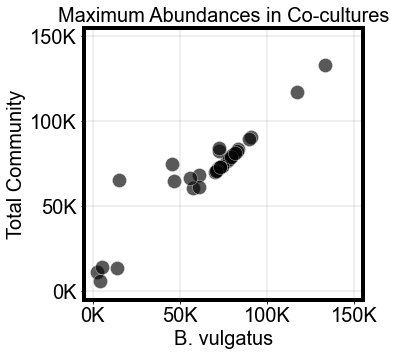

In [429]:
fig,ax = plt.subplots(figsize=[5,5])

scatter_kwargs = {'alpha':0.65,'edgecolor':'white','lw':0.5,'s':200}

g0 = df_results_wide_max_summary_wide.BV_Co.values#subsetDf(tmp,{'Substrate_Group':'Simple Sugars'})
g1 = df_results_wide_max_summary_wide.MaxCommCount.values#subsetDf(tmp,{'Substrate_Group':'Complex Sugars'})

ax.scatter(g0,g1,color='black',label='Simple',**scatter_kwargs)

largeTickLabels(ax,fontsize=20)
thicken_spines(ax,lw=4)

ax.yaxis.set_major_formatter(reformat_thousands_ticks)
ax.yaxis.set_major_locator(MultipleLocator(50000))
ax.xaxis.set_major_formatter(reformat_thousands_ticks)
ax.xaxis.set_major_locator(MultipleLocator(50000))

ax.yaxis.grid(lw=0.25,color='gray')
ax.xaxis.grid(lw=0.25,color='gray')

ax.set_xlim([-5000,155000])
ax.set_ylim([-5000,155000])

ax.set_xlabel('B. vulgatus',fontsize=20)
ax.set_ylabel('Total Community',fontsize=20)
ax.set_title('Maximum Abundances in Co-cultures',fontsize=20)
print(spearmanr(g0,g1))

plt.savefig(ParentPath+'/figures/bv_co_vs_max_comm_count.pdf',bbox_inches='tight')

In [584]:
## compute ProdRatio and add to dataframe
varbs = ['BO_Mono','BF_Mono','BT_Mono','BV_Mono']
monocounts = df_results_wide_max_summary_wide.loc[:,varbs].max(1)
prodratio = df_results_wide_max_summary_wide.MaxCommCount / monocounts
df_results_wide_max_summary_wide.loc[:,'ProdRatio'] = prodratio.values

SpearmanrResult(correlation=-0.5538101604278075, pvalue=0.0008271723889384458)


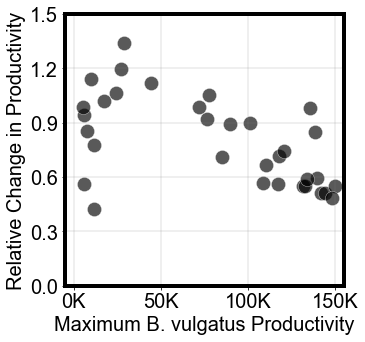

In [586]:
fig,ax = plt.subplots(figsize=[5,5])

scatter_kwargs = {'alpha':0.65,'edgecolor':'white','lw':0.5,'s':200}

g0 = df_results_wide_max_summary_wide.BV_Mono.values#subsetDf(tmp,{'Substrate_Group':'Simple Sugars'})
g1 = df_results_wide_max_summary_wide.ProdRatio.values#subsetDf(tmp,{'Substrate_Group':'Complex Sugars'})

ax.scatter(g0,g1,color='black',label='Simple',**scatter_kwargs)

largeTickLabels(ax,fontsize=20)
thicken_spines(ax,lw=4)

#ax.yaxis.set_major_formatter(reformat_thousands_ticks)
ax.yaxis.set_major_locator(MultipleLocator(0.3))
ax.xaxis.set_major_formatter(reformat_thousands_ticks)
ax.xaxis.set_major_locator(MultipleLocator(50000))

ax.yaxis.grid(lw=0.25,color='gray')
ax.xaxis.grid(lw=0.25,color='gray')

ax.set_xlim([-5000,155000])
ax.set_ylim([0,1.5])

ax.set_xlabel('Maximum B. vulgatus Productivity',fontsize=20)
ax.set_ylabel('Relative Change in Productivity',fontsize=20)

print(spearmanr(g0,g1))

plt.savefig(ParentPath + '/figures/bv_mono_vs_prod_ratio.pdf',bbox_inches='tight')

In [432]:
x_values_species = {'BO':0,'BF':2,'BT':4,'BV':6}
x_offset = {'Simple':0,'Complex':0.5}
color_dict = {'Simple':'#7fc97f','Complex':'#beaed4'}

BO
BO MannwhitneyuResult(statistic=163.0, pvalue=0.030195042621732098)
BF
BF MannwhitneyuResult(statistic=132.0, pvalue=0.37472795386566793)
BT
BT MannwhitneyuResult(statistic=183.0, pvalue=0.0027602785294304744)
BV
BV MannwhitneyuResult(statistic=174.0, pvalue=0.008750011959814027)


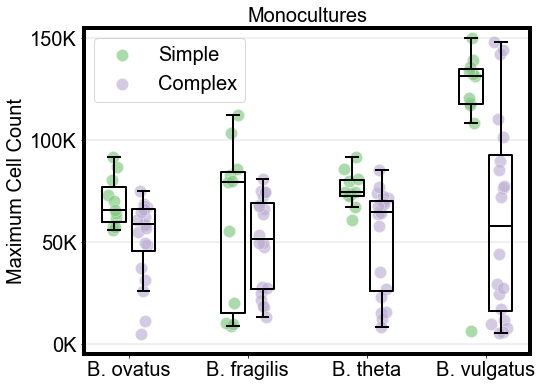

In [435]:

fig,ax = plt.subplots(figsize=[8,6])

scatter_kwargs = {'s':150,'edgecolor':'white','lw':0.5,'alpha':0.65}
boxplot_kwargs ={'showfliers':'False'}

kwargs_boxprops = {'lw':2,'color':'k','zorder':2}
kwargs_medianprops = {'lw':2,'color':'k'}
kwargs_whiskerprops = {'lw':2}
kwargs_capprops = {'lw':2}
                       
for species in ['BO','BF','BT','BV']:

    print(species)
    varbs = ['Species','Culture_Type','MaxSpCount','Substrate_Group']

    max_counts = df_results_max_summary.loc[:,varbs]
    max_counts = subsetDf(max_counts,{'Culture_Type':'Monoculture','Species':species})

    g0 = max_counts[max_counts.Substrate_Group=='Simple Sugars'].loc[:,'MaxSpCount'].values
    g1 = max_counts[max_counts.Substrate_Group=='Complex Sugars'].loc[:,'MaxSpCount'].values
    
    print(species,mannwhitneyu(g0,g1))

    y_values = g0
    x_mean = x_values_species[species]
    x_mean = x_mean + x_offset['Simple']
    x_values = np.random.normal(x_mean,0.05,len(y_values))
    
    if species == 'BV': 
        label = 'Simple' 
    else: 
        label = None
        
    ax.scatter(x_values,y_values,color=color_dict['Simple'],label=label,**scatter_kwargs)
    ax.boxplot(y_values,positions=[x_mean],widths=0.4,showfliers=False,
           boxprops=kwargs_boxprops,medianprops=kwargs_medianprops,whiskerprops=kwargs_whiskerprops,
              capprops=kwargs_capprops)
    
    y_values = g1
    x_mean = x_values_species[species]
    x_mean = x_mean + x_offset['Complex']
    x_values = np.random.normal(x_mean,0.05,len(y_values))
    
    if species == 'BV': 
        label = 'Complex' 
    else: 
        label = None
    ax.scatter(x_values,y_values,color=color_dict['Complex'],label=label,**scatter_kwargs)
    ax.boxplot(y_values,positions=[x_mean],widths=0.4,showfliers=False,
           boxprops=kwargs_boxprops,medianprops=kwargs_medianprops,whiskerprops=kwargs_whiskerprops,
              capprops=kwargs_capprops)
    
largeTickLabels(ax,fontsize=20)
thicken_spines(ax,lw=4)

ax.yaxis.set_major_formatter(reformat_thousands_ticks)
ax.yaxis.set_major_locator(MultipleLocator(50000))

ax.set_ylabel('Maximum Cell Count',fontsize=20)

xticks = [ii+0.25 for ii in x_values_species.values()];
xticklabels = [dict_species_labels[ii] for ii in x_values_species.keys()];
plt.setp(ax,xticks=xticks,xticklabels=xticklabels);

ax.set_ylim([-5000,155000])
ax.yaxis.grid(lw=1.5,alpha=0.25)
ax.set_title('Monocultures',fontsize=20)

ax.legend(fontsize=20)

plt.savefig(ParentPath + '/figures/max_counts_monocultures_by_species_complexity.pdf',bbox_inches='tight')

BO
BO MannwhitneyuResult(statistic=143.0, pvalue=0.10611516428394212)
BF
BF MannwhitneyuResult(statistic=110.5, pvalue=1.0)
BT
BT MannwhitneyuResult(statistic=176.0, pvalue=0.006189670420735247)
BV
BV MannwhitneyuResult(statistic=133.0, pvalue=0.3529211266525405)


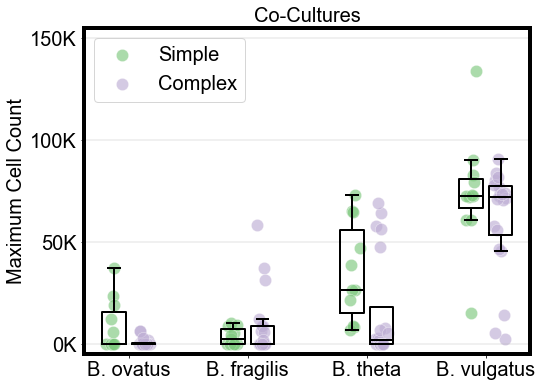

In [436]:

fig,ax = plt.subplots(figsize=[8,6])

scatter_kwargs = {'s':150,'edgecolor':'white','lw':0.5,'alpha':0.65}
boxplot_kwargs ={'showfliers':'False'}

kwargs_boxprops = {'lw':2,'color':'k','zorder':2}
kwargs_medianprops = {'lw':2,'color':'k'}
kwargs_whiskerprops = {'lw':2}
kwargs_capprops = {'lw':2}
                       
for species in ['BO','BF','BT','BV']:

    print(species)
    varbs = ['Species','Culture_Type','MaxSpCount','Substrate_Group']

    max_counts = df_results_max_summary.loc[:,varbs]
    max_counts = subsetDf(max_counts,{'Culture_Type':'Coculture','Species':species})

    g0 = max_counts[max_counts.Substrate_Group=='Simple Sugars'].loc[:,'MaxSpCount'].values
    g1 = max_counts[max_counts.Substrate_Group=='Complex Sugars'].loc[:,'MaxSpCount'].values
    
    print(species,mannwhitneyu(g0,g1))

    y_values = g0
    x_mean = x_values_species[species]
    x_mean = x_mean + x_offset['Simple']
    x_values = np.random.normal(x_mean,0.05,len(y_values))
    
    if species == 'BV': 
        label = 'Simple' 
    else: 
        label = None
        
    ax.scatter(x_values,y_values,color=color_dict['Simple'],label=label,**scatter_kwargs)
    ax.boxplot(y_values,positions=[x_mean],widths=0.4,showfliers=False,
           boxprops=kwargs_boxprops,medianprops=kwargs_medianprops,whiskerprops=kwargs_whiskerprops,
              capprops=kwargs_capprops)
    
    y_values = g1
    x_mean = x_values_species[species]
    x_mean = x_mean + x_offset['Complex']
    x_values = np.random.normal(x_mean,0.05,len(y_values))
    
    if species == 'BV': 
        label = 'Complex' 
    else: 
        label = None
        
    ax.scatter(x_values,y_values,color=color_dict['Complex'],label=label,**scatter_kwargs)
    ax.boxplot(y_values,positions=[x_mean],widths=0.4,showfliers=False,
           boxprops=kwargs_boxprops,medianprops=kwargs_medianprops,whiskerprops=kwargs_whiskerprops,
              capprops=kwargs_capprops)
    
largeTickLabels(ax,fontsize=20)
thicken_spines(ax,lw=4)

ax.yaxis.set_major_formatter(reformat_thousands_ticks)
ax.yaxis.set_major_locator(MultipleLocator(50000))

ax.set_ylabel('Maximum Cell Count',fontsize=20)

xticks = [ii+0.25 for ii in x_values_species.values()];
xticklabels = [dict_species_labels[ii] for ii in x_values_species.keys()];
plt.setp(ax,xticks=xticks,xticklabels=xticklabels);

ax.set_ylim([-5000,155000])
ax.yaxis.grid(lw=1.5,alpha=0.25)
ax.set_title('Co-Cultures',fontsize=20)

ax.legend(fontsize=20)

plt.savefig(ParentPath + '/figures/max_counts_cocultures_by_species_complexity.pdf',bbox_inches='tight')

BO SpearmanrResult(correlation=0.06154134128933684, pvalue=0.7336913437896002)
BF SpearmanrResult(correlation=0.2559574119492485, pvalue=0.1505061464685463)
BT SpearmanrResult(correlation=0.10286525808448901, pvalue=0.5689179614710802)
BV SpearmanrResult(correlation=0.5457887700534759, pvalue=0.0010187162265061364)


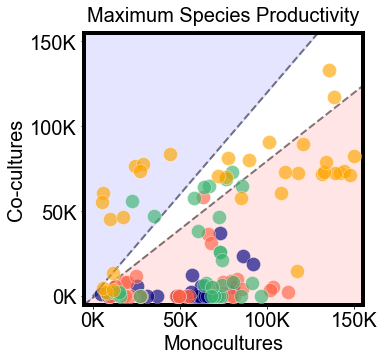

In [440]:
fig,ax = plt.subplots(figsize=[5,5])

for sp in ['BO','BF','BT','BV']:


    scatter_kwargs = {'alpha':0.65,'edgecolor':'white','lw':0.5,'s':200}

    g0 = df_results_wide_max_summary_wide[sp+'_Mono'].values#subsetDf(tmp,{'Substrate_Group':'Simple Sugars'})
    g1 = df_results_wide_max_summary_wide[sp+'_Co'].values#subsetDf(tmp,{'Substrate_Group':'Complex Sugars'})

    ax.scatter(g0,g1,color=dict_species_colors[sp],label='Simple',**scatter_kwargs,zorder=5)
    
    print(sp,spearmanr(g0,g1))
largeTickLabels(ax,fontsize=20)
thicken_spines(ax,lw=4)

ax.yaxis.set_major_formatter(reformat_thousands_ticks)
ax.yaxis.set_major_locator(MultipleLocator(50000))
ax.xaxis.set_major_formatter(reformat_thousands_ticks)
ax.xaxis.set_major_locator(MultipleLocator(50000))

ax.yaxis.grid(lw=0.25,color='gray')
ax.xaxis.grid(lw=0.25,color='gray')

ax.set_xlabel('Monocultures',fontsize=20)
ax.set_ylabel('Co-cultures',fontsize=20)

    # plt.savefig('./figures/bv_vs_comm_productivity.pdf',bbox_inches='tight')
    
plt.subplots_adjust(hspace=0.4,wspace=0.4)

ax.xaxis.grid(lw=0.25,color='gray')
ax.yaxis.grid(lw=0.25,color='gray')


ax.set_xlim([-5000,155000])
ax.set_ylim([-5000,155000])

x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.plot([x0,x1],[y0,0.8*y1],color=(0,0,0,0.5),ls='--',lw=2,zorder=2)
ax.plot([0,x1],[0,1.2*y1],color=(0,0,0,0.5),ls='--',lw=2,zorder=2)

ax.set_title('Maximum Species Productivity',fontsize=20,y=1.02)

#ax.annotate('20% higher growth',(80000,96000),rotation=45*1.1,va='bottom',ha='center',fontsize=10)


ax.fill_between(x=[-5000,x1],y1=[-5000*0.8,-5000*0.8],y2=[-5000*0.8,0.8*y1],color=(1,0,0,0.1),zorder=1)
ax.fill_between(x=[-5000,x1],y1=[-5000*1.2,1.2*y1],y2=[1.2*y1,1.2*y1],color=(0,0,1,0.1),zorder=1)


plt.savefig(ParentPath + '/figures/cocultures_vs_monocultures_scatter.pdf',bbox_inches='tight')

In [444]:
df_results_median.head()

,Substrate,TimePoint,Rep,BO,BF,BT,BV,CorrectedMixedCount,MixedRelAbund_BO,MixedRelAbund_BF,MixedRelAbund_BT,MixedRelAbund_BV,CorrectedMonoCount_BF,CorrectedMonoCount_BO,CorrectedMonoCount_BT,CorrectedMonoCount_BV,SimpsonEvenness,Substrate_Label,Substrate_Type,Substrate_Group
0,Amylopectin,24,1.5,0.0,4289.5,1096.0,8001.5,13387.0,0.000000,0.330954,0.084561,0.584484,15626.0,9896.5,13231.5,11168.5,0.377384,Amylopectin,Polysaccharide,Complex Sugars
1,Amylopectin,48,1.5,0.0,6224.5,658.5,2517.0,9400.0,0.000000,0.669994,0.077966,0.252040,13481.5,6798.5,10534.0,9746.0,0.452887,Amylopectin,Polysaccharide,Complex Sugars
2,Amylopectin,102,1.5,625.0,398.5,128.0,0.0,1151.5,0.549035,0.351121,0.099844,0.000000,2168.5,3389.5,5172.0,83.0,0.570569,Amylopectin,Polysaccharide,Complex Sugars
3,Arabinogalactan,24,1.5,0.0,0.0,2452.0,57285.0,59737.0,0.000000,0.000000,0.043758,0.956242,26520.5,31516.5,49608.5,65239.5,0.273759,Arabinogalactan,Polysaccharide,Complex Sugars
4,Arabinogalactan,48,1.5,0.0,0.0,6277.0,44225.5,50502.5,0.000000,0.000000,0.124248,0.875752,20809.5,29871.5,60925.5,75875.5,0.319885,Arabinogalactan,Polysaccharide,Complex Sugars


In [446]:
df_results_max

,Substrate,TimePoint,Rep,BO,BF,BT,BV,CorrectedMixedCount,MixedRelAbund_BO,MixedRelAbund_BF,MixedRelAbund_BT,MixedRelAbund_BV,CorrectedMonoCount_BF,CorrectedMonoCount_BO,CorrectedMonoCount_BT,CorrectedMonoCount_BV,Substrate_Label,Substrate_Type,Substrate_Group,SimpsonEvenness
0,Amylopectin,24,2.0,0.0,8579.0,2192.0,13813.0,13813.0,0.00000,0.661909,0.169123,1.000000,16579.0,10889.0,14137.0,11652.0,Amylopectin,Polysaccharide,Complex,0.504769
1,Amylopectin,48,2.0,0.0,6309.0,1317.0,4214.0,10354.0,0.00000,0.746981,0.155932,0.406992,17736.0,7471.0,15041.0,10876.0,Amylopectin,Polysaccharide,Complex,0.483278
2,Amylopectin,102,2.0,633.0,404.0,256.0,0.0,1282.0,0.60431,0.395690,0.199688,0.000000,2199.0,3954.0,5771.0,166.0,Amylopectin,Polysaccharide,Complex,0.661992
3,Arabinogalactan,24,2.0,0.0,0.0,4904.0,63438.0,63438.0,0.00000,0.000000,0.087515,1.000000,27593.0,32091.0,51495.0,69108.0,Arabinogalactan,Polysaccharide,Complex,0.297517
4,Arabinogalactan,48,2.0,0.0,0.0,7855.0,45733.0,50573.0,0.00000,0.000000,0.155320,0.906825,22012.0,33178.0,62948.0,79096.0,Arabinogalactan,Polysaccharide,Complex,0.338933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,Xylan,102,2.0,0.0,0.0,56339.0,67634.0,80324.0,0.00000,0.000000,0.701397,1.000000,1845.0,42342.0,19682.0,77516.0,Xylan,Polysaccharide,Complex,0.430203
118,mGifu,24,2.0,0.0,3490.0,0.0,69866.0,72033.0,0.00000,0.048472,0.000000,0.969917,82970.5,65299.0,74527.5,138520.0,mGAM (Rich Media),Rich_Media,NaN,0.275405
119,mGifu,48,2.0,0.0,0.0,0.0,106671.0,106671.0,0.00000,0.000000,0.000000,1.000000,87791.0,56002.0,79101.0,122029.5,mGAM (Rich Media),Rich_Media,NaN,0.250000
120,mGifu,72,2.0,0.0,0.0,0.0,117383.0,117383.0,0.00000,0.000000,0.000000,1.000000,101549.0,70021.0,96412.0,130014.0,mGAM (Rich Media),Rich_Media,NaN,0.250000


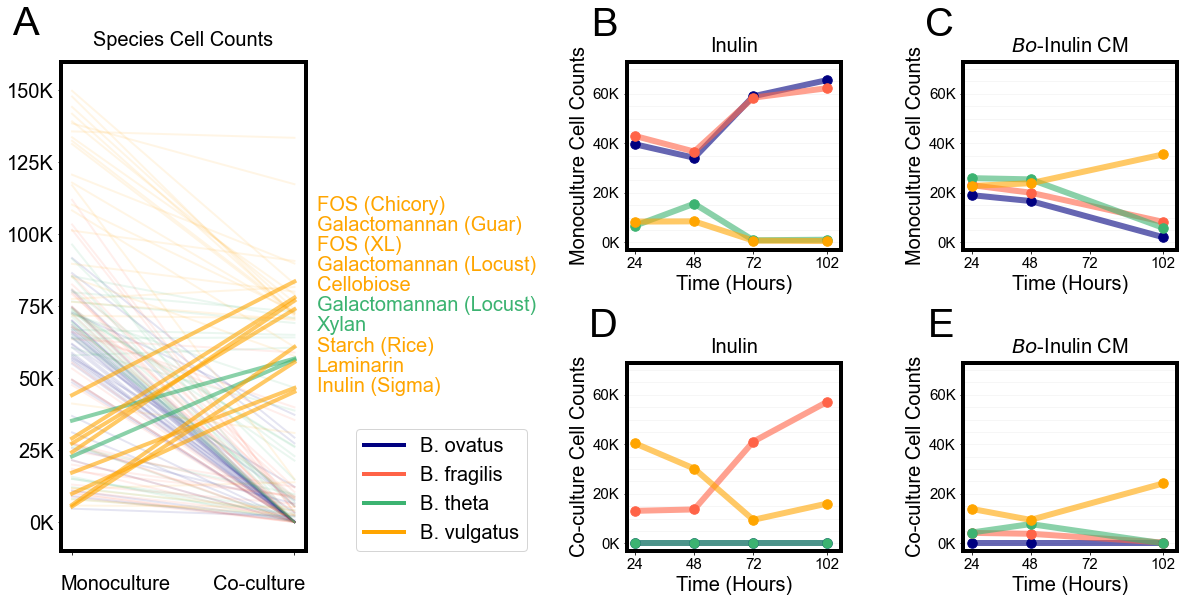

In [459]:
fig = plt.figure(tight_layout = False,figsize=[20,9])
gs = gridspec.GridSpec(2,5,width_ratios=[1.6,2.1,1.4,0.8,1.4])

ax_main = fig.add_subplot(gs[:,0])
ax_text = fig.add_subplot(gs[:,1])
ax_1 = fig.add_subplot(gs[1,2])
ax_2 = fig.add_subplot(gs[1,4])
ax_3 = fig.add_subplot(gs[0,2])
ax_4 = fig.add_subplot(gs[0,4])
ax_remove = fig.add_subplot(gs[:,3])

plt.subplots_adjust(wspace=0,hspace=0.60)

ax = ax_main
annotations = []#pd.DataFrame(columns=['Substrate','Color','ypos'])

for sp in ['BO','BF','BT','BV']:
    
    toplot = df_results_max.loc[:,['Substrate','TimePoint','CorrectedMonoCount_'+sp]]
    toplot = toplot.pivot(index='Substrate',columns=['TimePoint'],values='CorrectedMonoCount_'+sp)
    max_counts_mono = pd.DataFrame(toplot.max(1),columns=['Mono'])


    toplot = df_results_max.loc[:,['Substrate','TimePoint','MixedRelAbund_'+sp,'CorrectedMixedCount']]
    toplot.loc[:,'MixedAbsAbund_'+sp] = toplot.apply(lambda x: x['MixedRelAbund_'+sp] * x['CorrectedMixedCount'],axis=1).values
    toplot = toplot.pivot(index='Substrate',columns=['TimePoint'],values='MixedAbsAbund_'+sp)
    max_counts_co = pd.DataFrame(toplot.max(1),columns=['Co'])
    max_counts = max_counts_mono.join(max_counts_co).sort_values(['Mono'])

    for idx,row in max_counts.iterrows():
        
        if row['Co'] / row['Mono'] < 1.2:
            color = dict_species_colors[sp]
            lw = 2
            alpha = 0.1
        else:
            color = dict_species_colors[sp]
            lw = 4
            alpha = 0.6
        
        ax.plot([0,1],row.values,color=color,alpha=alpha,lw=lw)
        
        if lw == 4: annotations.append([idx,color,row.values[1]])   
            
thicken_spines(ax,lw=4)
largeTickLabels(ax)

ax_text.set_xlim(ax_main.get_xlim())
ax_text.set_ylim(ax_main.get_ylim())
xlims = ax_text.get_xlim()
artists = {}
for species,color in dict_species_colors.items():
    aa = ax_main.plot([-2,-1],[0,0],color=color,lw=4)
    artists[dict_species_labels[species]] = aa[0]
ax.set_xlim(xlims)
    
ax.yaxis.set_major_formatter(FuncFormatter(reformat_thousands_ticks))
ax.yaxis.set_major_locator(MultipleLocator(25000))
ax.set_ylim([-10000,160000])

plt.setp(ax,xticks=[0,1],xticklabels=['',''])

ax.text(0,-0.05,'Monoculture',fontsize=20,ha='left',va='top',transform=ax.transAxes)
ax.text(1,-0.05,'Co-culture',fontsize=20,ha='right',va='top',transform=ax.transAxes)
ax.set_title('Species Cell Counts',fontsize=20,y=1.02)

annotations = pd.DataFrame(annotations,columns=['Substrate','Color','Y'])
annotations = annotations.sort_values(['Y'])
annotations_copy = annotations.copy()
y_values = annotations_copy.Y.values
for ii in range(annotations_copy.shape[0]-1):
    while y_values[ii+1] - y_values[ii] < 7000: y_values[ii+1] = y_values[ii] + 7000
annotations_copy.loc[:,'Y'] = y_values


for idx,row in annotations_copy.iterrows():
    
    ax_main.text(1.1,row['Y'],dict_substrate_label[row['Substrate']],color=row['Color'],  fontsize=20)

## add legend
x0 = ax_main.get_position().x1
y0 = ax_main.get_position().y0 

lgd = ax_main.legend(artists.values(),artists.keys(),loc='lower left',
                bbox_to_anchor=(x0+0.035,y0),fontsize=20,borderaxespad=0,
                bbox_transform=fig.transFigure,frameon=True)

[ax_text.spines[ii].set(lw=0) for ii in ['left','top','right','bottom']]


fig.delaxes(ax_text)
fig.delaxes(ax_remove)

##

ax_ii = [ax_1,ax_2,ax_3,ax_4]

varbs1 = ['Substrate','TimePoint','Rep','CorrectedMixedCount']
varbs = varbs1 + ['BO','BF','BT','BV']
abundances_over_time = df_results.loc[:,varbs]

tps = [24,48,72,102]
artists = {}

lines_kw = {'alpha':0.6,'lw':6,'zorder':2}
scatter_kw = {'s':90,'marker':'o','zorder':3}

for ii,substrate in [(ax_1,'Inulin_Sigma'),(ax_2,'Inulin_Breakdown_Byproducts')]:
    ax = ii

    x_values = tps
    y_values = subsetDf(abundances_over_time,{'Substrate':substrate})
    y_values = y_values.drop(['Rep','Substrate','CorrectedMixedCount'],axis=1)
    y_values = y_values.groupby(['TimePoint']).median()
    if 72 not in y_values.index.values: 
        x_values = [24,48,102]
        y_values.loc[72,:] = np.nan
    y_values = y_values.sort_index()
    y_values = y_values.T.join(color_df)

    for idx,row in y_values.iterrows():
        aa = ax.plot(x_values,row[x_values],color=row['Color'],**lines_kw)
        ax.scatter(x_values,row[x_values],color=row['Color'],**scatter_kw)
        artists[dict_species_labels[idx]] = aa[0]

##

varbs1 = ['Substrate','TimePoint','Rep']
varbs = varbs1 + ['CorrectedMonoCount_{}'.format(ii) for ii in ['BO','BF','BT','BV']]
abundances_over_time = df_results.loc[:,varbs]
abundances_over_time.columns = varbs1 + ['BO','BF','BT','BV']

tps = [24,48,72,102]

for ii,substrate in [(ax_3,'Inulin_Sigma'),(ax_4,'Inulin_Breakdown_Byproducts')]:
    ax = ii

    x_values = tps
    y_values = subsetDf(abundances_over_time,{'Substrate':substrate})
    y_values = y_values.drop(['Rep','Substrate'],axis=1)
    y_values = y_values.groupby(['TimePoint']).median()
    if 72 not in y_values.index.values: 
        x_values = [24,48,102]
        y_values.loc[72,:] = np.nan
    y_values = y_values.sort_index()
    y_values = y_values.T.join(color_df)

    for idx,row in y_values.iterrows():
        aa = ax.plot(x_values,row[x_values],color=row['Color'],**lines_kw)
        ax.scatter(x_values,row[x_values],color=row['Color'],**scatter_kw)
        artists[dict_species_labels[idx]] = aa[0]
        
####

for ax in ax_ii:
    thicken_spines(ax,lw=4)
    largeTickLabels(ax,fontsize=15)
    
    ax.set_ylim([-3000,73000])
    ax.set_xlim([20.5,107.5])
    
    ax.yaxis.set_major_formatter(FuncFormatter(reformat_thousands_ticks))
    ax.yaxis.set_major_locator(MultipleLocator(20000))
    ax.yaxis.set_minor_locator(MultipleLocator(5000))
    
    ax.yaxis.grid(which='Minor',color='#EEEEEE',lw=0.5,ls='-',zorder=1)
    ax.yaxis.grid(which='Major',color='#EEEEEE',lw=0.5,ls='-',zorder=1)
    
    plt.setp(ax,xticks=[24,48,72,102])
    
plt.setp(ax,xticks=[24,48,72,102],xticklabels=[24,48,72,102])

ax_3.set_title('Inulin',fontsize=20,y=1.02)
ax_4.set_title(r'$\it{Bo}$-Inulin CM',fontsize=20,y=1.02)

ax_1.set_title('Inulin',fontsize=20,y=1.02)
ax_2.set_title(r'$\it{Bo}$-Inulin CM',fontsize=20,y=1.02)

ax_3.set_ylabel('Monoculture Cell Counts',fontsize=20)
ax_1.set_ylabel('Co-culture Cell Counts',fontsize=20)

ax_4.set_ylabel('Monoculture Cell Counts',fontsize=20)
ax_2.set_ylabel('Co-culture Cell Counts',fontsize=20)


ax_1.set_xlabel('Time (Hours)',fontsize=20)
ax_2.set_xlabel('Time (Hours)',fontsize=20)
ax_3.set_xlabel('Time (Hours)',fontsize=20)
ax_4.set_xlabel('Time (Hours)',fontsize=20)

ax_main.text(-0.15,ax_main.get_ylim()[1]*1.04,'A',
        fontsize=40, transform = ax_main.transData,ha='right',va='bottom')

ax_3.text(17,ax_3.get_ylim()[1]*1.1,'B',
        fontsize=40, transform = ax_3.transData,ha='right',va='bottom')

ax_4.text(17,ax_4.get_ylim()[1]*1.1,'C',
        fontsize=40, transform = ax_4.transData,ha='right',va='bottom')

ax_1.text(17,ax_1.get_ylim()[1]*1.1,'D',
        fontsize=40, transform = ax_1.transData,ha='right',va='bottom')

ax_2.text(17,ax_2.get_ylim()[1]*1.1,'E',
        fontsize=40, transform = ax_2.transData,ha='right',va='bottom')

plt.savefig(ParentPath + '/figures/b_vulgatus_cross_feeding.pdf',bbox_inches='tight')

## Generate Figures

**Maintain similar order of substrates in different plots**
Order is based on the average of total growths in coc-cultures.

In [ ]:
substrate_order = df_results_filtered.groupby(['Substrate']).median()['CorrectedMixedCount']
substrate_order = substrate_order.sort_values().index.values
substrate_order

In [376]:
df_results_filtered = df_results[df_results.Substrate!='Inulin_Breakdown_Byproducts']    b

### grid plot of relative abundance heatmaps

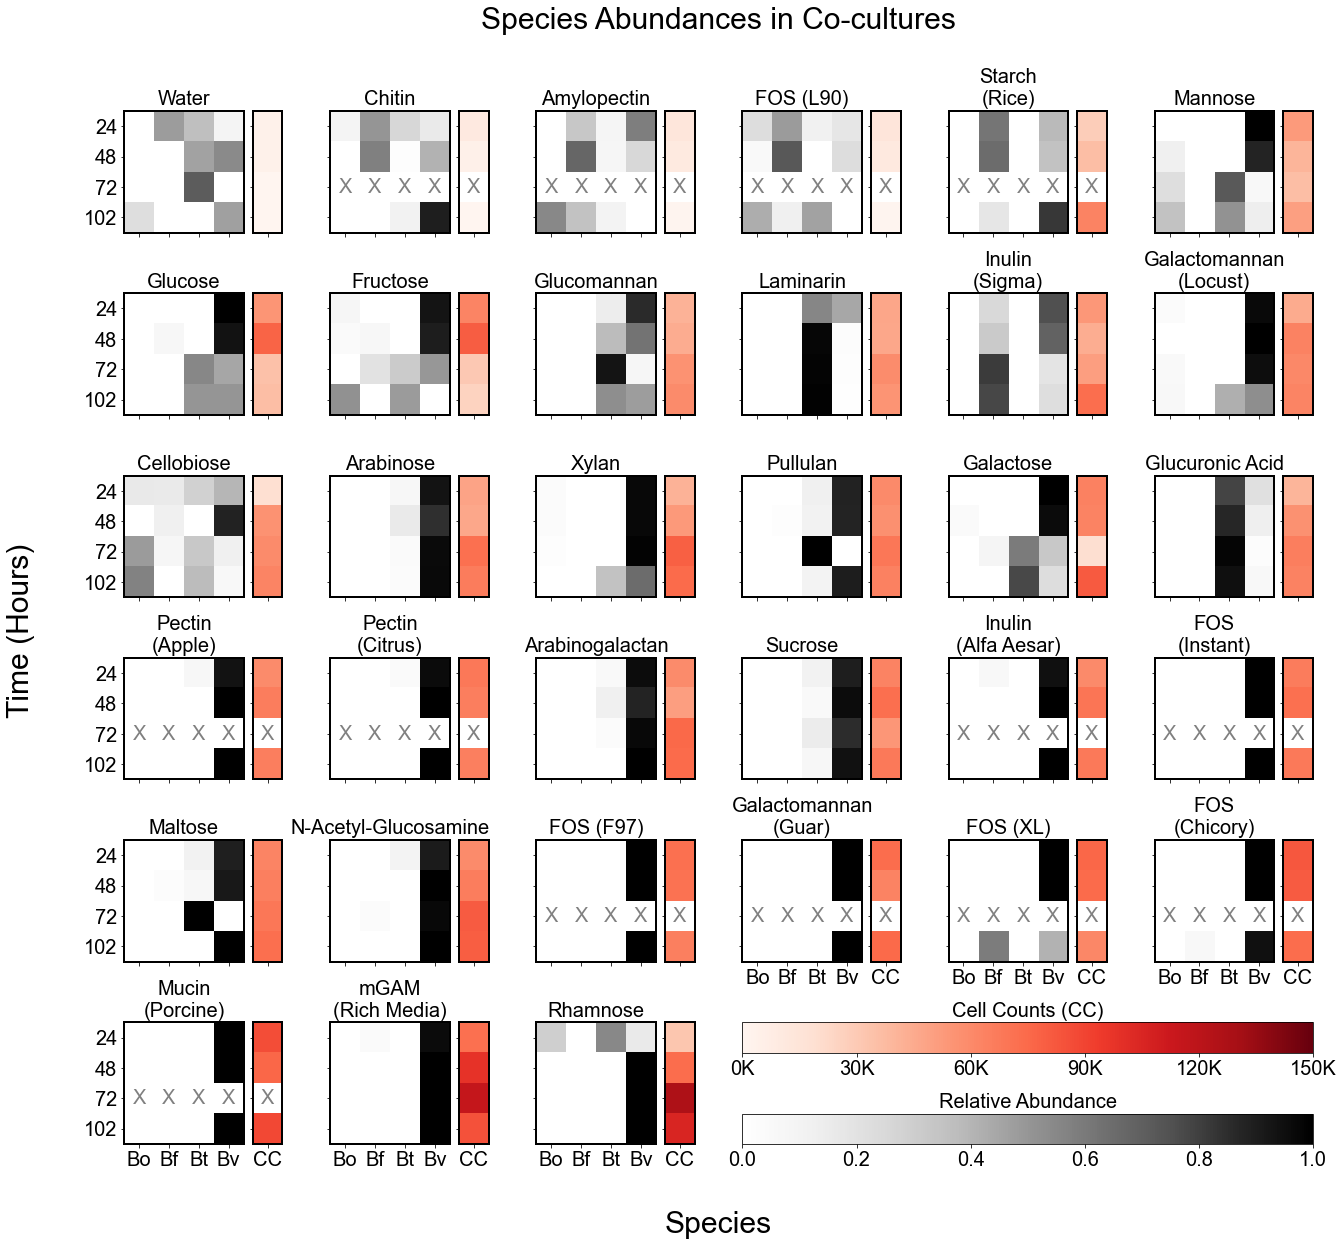

In [381]:
varbs1 = ['Substrate','TimePoint','Rep','CorrectedMixedCount']
varbs = varbs1+ ['MixedRelAbund_'+ii for ii in ['BO','BF','BT','BV']]
abundances_over_time = df_results_filtered.loc[:,varbs]
abundances_over_time.columns = varbs1 + ['BO','BF','BT','BV']


fig,axes = plt.subplots(6,18,figsize=[22,19],sharex=False,sharey=True,
                      gridspec_kw={'width_ratios':np.ravel([4,1,1]*6)})
ax_ii = np.ravel(axes)

text_kwargs = {'fontsize':20,'ha':'center','va':'center','color':'gray'}

for ii, substrate in enumerate(substrate_order):
    
    ax_ra = ax_ii[(ii*3)+0]
    ax_aa = ax_ii[(ii*3)+1]
    ax_del = ax_ii[(ii*3)+2]
    
    y_values = subsetDf(abundances_over_time,{'Substrate':substrate})
    y_values = y_values.groupby(['TimePoint']).median()
    y_values = y_values['CorrectedMixedCount'].sort_index()
    if 72 not in y_values.index.values: y_values.loc[72] = np.nan
    y_values = y_values.sort_index().values[:,np.newaxis]
    
    im_aa = ax_aa.imshow(y_values,cmap='Reds',aspect='auto',vmin=0,vmax=150000)
    
    thicken_spines(ax_aa,lw=2)
    largeTickLabels(ax_aa,fontsize=20)
    
    fig.delaxes(ax_del)
    
    y_values = subsetDf(abundances_over_time,{'Substrate':substrate})
    y_values = y_values.drop(['Rep','Substrate','CorrectedMixedCount'],axis=1)
    y_values = y_values.groupby(['TimePoint']).median()
    if 72 not in y_values.index.values: y_values.loc[72,:] = [np.nan]*4
    y_values = y_values.sort_index()
        
    im_ra = ax_ra.imshow(y_values,cmap='Greys',aspect='auto',vmin=0,vmax=1.0)
    
    title = dict_substrate_label[substrate]
    if len(title) > 12: title = title.replace(' (','\n(')
    ax_ra.set_title(title,fontsize=20)
    
    thicken_spines(ax_ra,lw=2)
    largeTickLabels(ax_ra,fontsize=20)
    
    if len(substrate_order) - ii <=6: 
        plt.setp(ax_ra,xticks=[0,1,2,3],xticklabels=['Bo','Bf','Bt','Bv'])
        plt.setp(ax_aa,xticks=[0],xticklabels=['CC'])
        
    else: 
        plt.setp(ax_ra,xticks=[0,1,2,3],xticklabels=[])
        plt.setp(ax_aa,xticks=[0],xticklabels=[])
    
    if np.isnan(y_values.loc[72,'BO']):
        [ax_ra.text(jj,2,'X',**text_kwargs) for jj in range(4)]
        ax_aa.text(0,2,'X',**text_kwargs)
    
plt.setp(ax_ra,yticks=[0,1,2,3],yticklabels=[24,48,72,102])
plt.subplots_adjust(hspace=0.5,wspace=0.15)

for dd in range(3*(ii+1),36*3):  fig.delaxes(ax_ii[dd])

plt.setp(ax_ii[84],xticks=[0,1,2,3],xticklabels=['Bo','Bf','Bt','Bv'])
plt.setp(ax_ii[87],xticks=[0,1,2,3],xticklabels=['Bo','Bf','Bt','Bv'])
plt.setp(ax_ii[85],xticks=[0],xticklabels=['CC'])
plt.setp(ax_ii[88],xticks=[0],xticklabels=['CC'])

ax_ra_left = axes[5,9]
ax_ra_right = axes[5,16]

x0 = ax_ra_left.get_position().x0
y0 = ax_ra_left.get_position().y0 
dx = ax_ra_right.get_position().x1 - x0
dy = axes[0,0].get_position().height

cbar_ax_ra = fig.add_axes([x0,y0,dx,dy*0.25])
cbar_ax_aa = fig.add_axes([x0,y0+dy*0.75,dx,dy*0.25])

fig.colorbar(im_ra,cbar_ax_ra,orientation='horizontal')
fig.colorbar(im_aa,cbar_ax_aa,orientation='horizontal')

cbar_ax_aa.xaxis.set_major_formatter(FuncFormatter(reformat_thousands_ticks))
cbar_ax_aa.set_xlim([0,150000])  
cbar_ax_aa.xaxis.set_major_locator(MultipleLocator(30000))

cbar_ax_ra.set_xlim([0.0,1.0])
cbar_ax_ra.xaxis.set_major_locator(MultipleLocator(0.2))

cbar_ax_ra.set_title('Relative Abundance',fontsize=20)
cbar_ax_aa.set_title('Cell Counts (CC)',fontsize=20)

largeTickLabels(cbar_ax_ra,fontsize=20)
largeTickLabels(cbar_ax_aa,fontsize=20)

t1=fig.text(0.5,0.06,"Species",ha='center',fontsize=30)
t2=fig.text(0.06,0.5,"Time (Hours)",ha='center',va='center',rotation='vertical',fontsize=30)
t3=fig.text(0.5,.94,'Species Abundances in Co-cultures',ha='center',fontsize=30)

plt.savefig(ParentPath + '/figures/grid_plot_abundance_heatmaps.pdf',bbox_inches='tight',bbox_extra_artists=(t1,t2,t3))

### grid plot of growth curves for monocultures

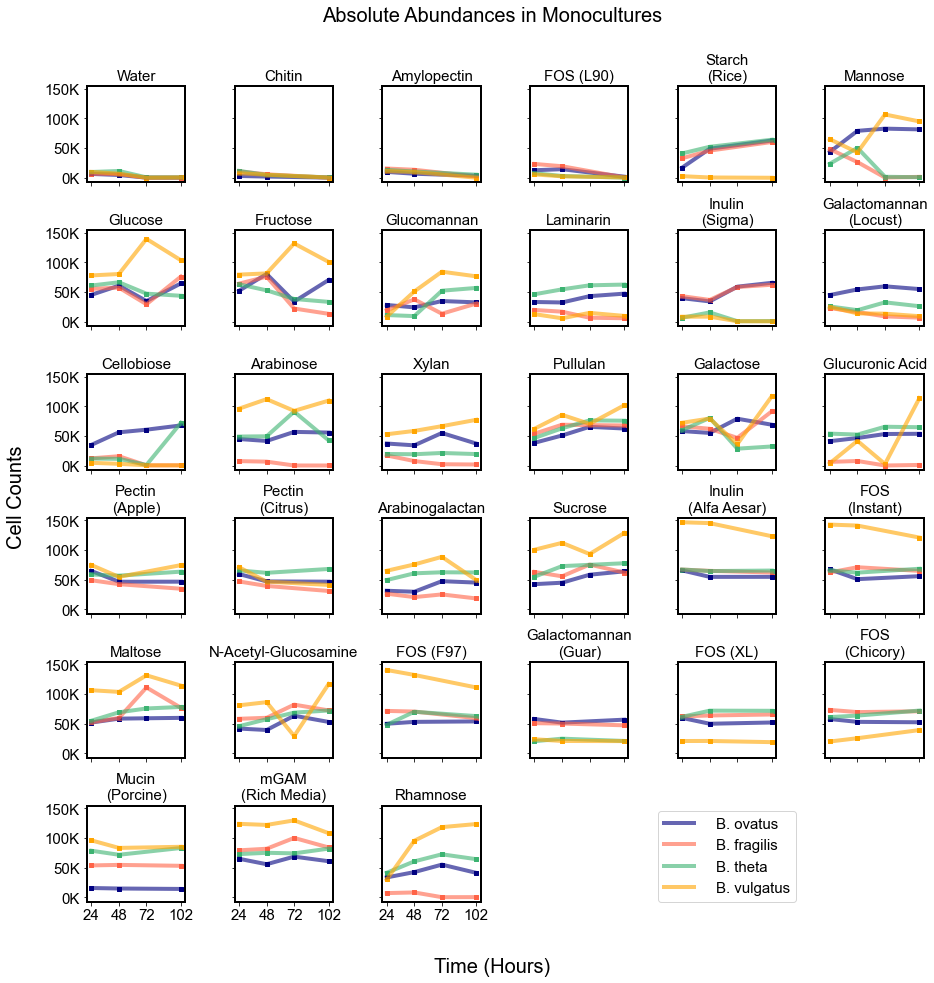

In [383]:
varbs1 = ['Substrate','TimePoint','Rep']
varbs = varbs1 + ['CorrectedMonoCount_{}'.format(ii) for ii in ['BO','BF','BT','BV']]
abundances_over_time = df_results_filtered.loc[:,varbs]
abundances_over_time.columns = varbs1 + ['BO','BF','BT','BV']

fig,axes = plt.subplots(6,6,figsize=[15,15],sharex=True,sharey=True)
ax_ii = np.ravel(axes)

tps = [24,48,72,102]

artists = {}
for ii, substrate in enumerate(substrate_order):
    
    x_values = tps
    y_values = subsetDf(abundances_over_time,{'Substrate':substrate})
    y_values = y_values.drop(['Rep','Substrate'],axis=1)
    y_values = y_values.groupby(['TimePoint']).median()
    if 72 not in y_values.index.values: 
        y_values.loc[72,:] = [np.nan]*4
        x_values = [24,48,102]
    y_values = y_values.sort_index()
    y_values = y_values.T.join(color_df)

    ax = ax_ii[ii]
    
    for idx,row in y_values.iterrows(): 
        aa = ax.plot(x_values,row[x_values],color=row['Color'],lw=4,alpha=0.6)
        ax.scatter(x_values,row[x_values],color=row['Color'],s=20,marker="s")
        artists[dict_species_labels[idx]] = aa[0]
        
    title = dict_substrate_label[substrate]
    if len(title) > 12: title = title.replace(' (','\n(')
    ax.set_title(title,fontsize=15)
    
    if len(substrate_order) - ii <=6: plt.setp(ax,xticks=[24,48,72,102],xticklabels=[24,48,72,102])
    else: plt.setp(ax,xticks=[24,48,72,102],xticklabels=[])
    
    thicken_spines(ax,lw=2)
    largeTickLabels(ax,fontsize=15)
    
plt.setp(ax,xticks=[24,48,72,102],xticklabels=[24,48,72,102])

ax.yaxis.set_major_formatter(FuncFormatter(reformat_thousands_ticks))

#for dd in range(ii+1,36): fig.delaxes(ax_ii[dd])
    
plt.subplots_adjust(hspace=0.5,wspace=0.5)

t1=fig.text(0.50,.06,"Time (Hours)",ha='center',fontsize=20)
t2=fig.text(0.06,0.5,"Cell Counts",ha='center',va='center',rotation='vertical',fontsize=20)
t3=fig.text(0.50,0.94,'Absolute Abundances in Monocultures',ha='center',fontsize=20)

## add legend
w0 = axes[5,4].get_position().x1 - axes[5,4].get_position().x0
x0 = axes[5,4].get_position().x0 + w0*0.5
y0 = axes[5,4].get_position().y0 

lgd = ax_ii[32].legend(artists.values(),artists.keys(),loc='lower center',
                 bbox_to_anchor=(x0,y0),fontsize=15,handlelength=2,handletextpad=1.5,borderaxespad=0,
                 bbox_transform=fig.transFigure)

fig.delaxes(ax_ii[33])
fig.delaxes(ax_ii[34])
fig.delaxes(ax_ii[35])

plt.savefig(ParentPath + '/figures/grid_plot_growth_cruves_monocultures.pdf', bbox_inches='tight',bbox_extra_artists=(t1,t2,t3))

### grid plot of growth curves for cocultures

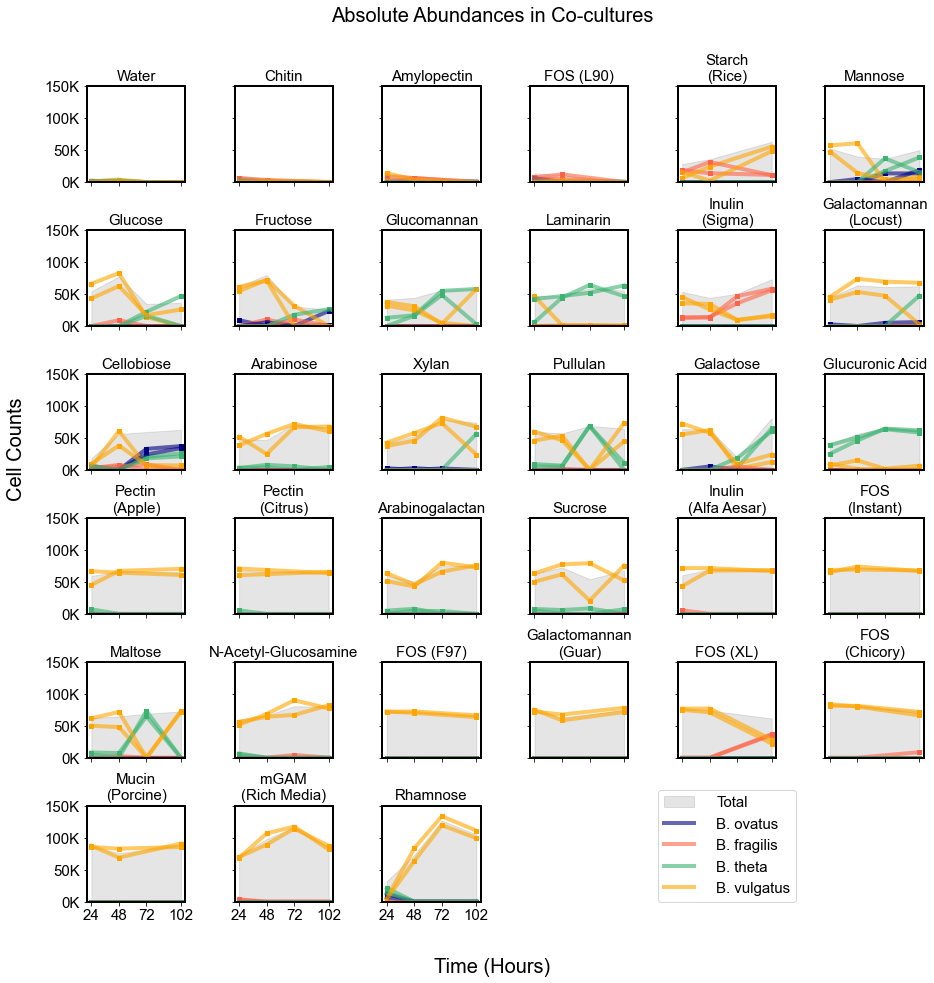

In [384]:
varbs1 = ['Substrate','TimePoint','Rep','CorrectedMixedCount']
varbs = varbs1 + ['BO','BF','BT','BV']
abundances_over_time = df_results_filtered.loc[:,varbs]

fig,axes = plt.subplots(6,6,figsize=[15,15],sharex=True,sharey=True)
ax_ii = np.ravel(axes)

tps = [24,48,72,102]

artists = {}

for ii, substrate in enumerate(substrate_order):
    
    ax = ax_ii[ii]

    x_values = tps
    y_values = subsetDf(abundances_over_time,{'Substrate':substrate})
    y_values = y_values.groupby(['TimePoint']).median()
    y_values = y_values['CorrectedMixedCount'].sort_index()
    if 72 not in y_values.index.values: 
        #y_values.loc[72] = np.nan
        x_values = [24,48,102]
    y_values = y_values.sort_index().values#[:,np.newaxis]

    aa = ax.fill_between(x_values,[0]*len(x_values),y_values,color=(0,0,0,0.1),label='Total')
    artists['Total'] = aa
    
    for rr in [1,2]:
        x_values = tps
        y_values = subsetDf(abundances_over_time,{'Substrate':substrate,'Rep':rr})
        y_values = y_values.drop(['Rep','Substrate','CorrectedMixedCount'],axis=1)
        y_values = y_values.groupby(['TimePoint']).median()
        if 72 not in y_values.index.values: 
            y_values.loc[72,:] = np.nan
            x_values = [24,48,102]
        y_values = y_values.sort_index()
        y_values = y_values.T.join(color_df)

        for idx,row in y_values.iterrows(): 
            aa = ax.plot(x_values,row[x_values],color=row['Color'],alpha=0.6,label=idx,lw=4)
            ax.scatter(x_values,row[x_values],color=row['Color'],s=20,marker="s")
            artists[dict_species_labels[idx]] = aa[0]
            
    title = dict_substrate_label[substrate]
    if len(title) > 12: title = title.replace(' (','\n(')
    ax.set_title(title,fontsize=15)
    
    if len(substrate_order) - ii <=6: plt.setp(ax,xticks=[24,48,72,102],xticklabels=[24,48,72,102])
    else: plt.setp(ax,xticks=[24,48,72,102],xticklabels=[])
    
    thicken_spines(ax,lw=2)
    largeTickLabels(ax,fontsize=15)
    
plt.setp(ax,xticks=[24,48,72,102],xticklabels=[24,48,72,102])

ax.yaxis.set_major_formatter(FuncFormatter(reformat_thousands_ticks))
ax.yaxis.set_major_locator(MultipleLocator(50000))
ax.set_ylim([0,150000])
    
plt.subplots_adjust(hspace=0.5,wspace=0.5)

t1=fig.text(0.50,.06,"Time (Hours)",ha='center',fontsize=20)
t2=fig.text(0.06,0.5,"Cell Counts",ha='center',rotation='vertical',fontsize=20)
t3=fig.text(0.50,0.94,'Absolute Abundances in Co-cultures',ha='center',fontsize=20)

## add legend
w0 = axes[5,4].get_position().x1 - axes[5,4].get_position().x0
x0 = axes[5,4].get_position().x0 + w0*0.5
y0 = axes[5,4].get_position().y0 

lgd = ax_ii[32].legend(artists.values(),artists.keys(),loc='lower center',
                 bbox_to_anchor=(x0,y0),fontsize=15,handlelength=2,handletextpad=1.5,borderaxespad=0,
                 bbox_transform=fig.transFigure)

fig.delaxes(ax_ii[33])
fig.delaxes(ax_ii[34])
fig.delaxes(ax_ii[35])

plt.savefig(ParentPath + '/figures/grid_plot_growth_cruves_cocultures.pdf', bbox_inches='tight',bbox_extra_artists=(t1,t2,t3))

### tradeffs of productivity and diversity 

In [460]:
varbs = ['Substrate','TimePoint']
varbs+= ['CorrectedMonoCount_'+ii for ii in ['BO','BF','BT','BV']]
                                   
max_counts = df_results_median
max_counts.Substrate = max_counts.Substrate.replace({'Cellibiose':'Cellobiose'})
max_counts = max_counts.loc[:,varbs]
max_counts = max_counts.set_index(['Substrate','TimePoint']).max(1).reset_index()
max_counts = max_counts.pivot(index='Substrate',columns='TimePoint',values=0)
max_counts = pd.DataFrame(max_counts.max(1).sort_values(),columns=['MaxCount'])
max_counts = substrate_descriptions.join(max_counts).dropna()
max_counts_mono = max_counts
max_counts.head()

,Substrate_Label,Substrate_Type,Substrate_Group,MaxCount
Substrate,,,,
Cellobiose,Cellobiose,Disaccharide,Simple Sugars,72016.0
Maltose,Maltose,Disaccharide,Simple Sugars,131570.5
Sucrose,Sucrose,Disaccharide,Simple Sugars,128639.0
Arabinose,Arabinose,Monosaccharide,Simple Sugars,111965.0
Fructose,Fructose,Monosaccharide,Simple Sugars,131821.0


In [463]:
d1 = max_counts[max_counts.Substrate_Group=='Complex Sugars'].MaxCount.values
d2 = max_counts[max_counts.Substrate_Group=='Simple Sugars'].MaxCount.values

d1_mono = d1
d2_mono = d2

kruskal(d1,d2)

KruskalResult(statistic=8.352272727272705, pvalue=0.0038520520657848232)

In [466]:
varbs = ['Substrate','TimePoint','CorrectedMixedCount']
                                   
max_counts = df_results_median
max_counts.Substrate = max_counts.Substrate.replace({'Cellibiose':'Cellobiose'})
max_counts = max_counts.loc[:,varbs]

# get TOTAL absolute abundance for each condition
max_counts = max_counts.pivot(index='Substrate',columns='TimePoint',values='CorrectedMixedCount')

# get maximum TOTAL absolute abundance regardless of time
max_counts = pd.DataFrame(max_counts.max(1).sort_values(),columns=['MaxTotalCountDirect'])

# save results
max_counts = substrate_descriptions.join(max_counts).dropna()
max_counts_co_total_direct = max_counts
max_counts_co_total_direct.head()

,Substrate_Label,Substrate_Type,Substrate_Group,MaxTotalCountDirect
Substrate,,,,
Cellobiose,Cellobiose,Disaccharide,Simple Sugars,62692.0
Maltose,Maltose,Disaccharide,Simple Sugars,72325.5
Sucrose,Sucrose,Disaccharide,Simple Sugars,72424.5
Arabinose,Arabinose,Monosaccharide,Simple Sugars,72043.0
Fructose,Fructose,Monosaccharide,Simple Sugars,79768.0


In [467]:
d1 = max_counts_co_total_direct[max_counts_co_total_direct.Substrate_Group=='Complex Sugars'].MaxTotalCountDirect.values
d2 = max_counts_co_total_direct[max_counts_co_total_direct.Substrate_Group=='Simple Sugars'].MaxTotalCountDirect.values

d1_co = d1
d2_co = d2

kruskal(d1,d2)

KruskalResult(statistic=2.0880681818181728, pvalue=0.14845368874975076)

In [469]:
max_counts_mono_red = max_counts_mono.loc[:,['Substrate_Group','MaxCount']]
max_counts_mono_red.columns = ['Substrate_Group','MaxCountMono']
max_counts_co_red = max_counts_co_total_direct.loc[:,['MaxTotalCountDirect']]
max_counts_co_red.columns = ['MaxCountCo']

In [470]:
max_counts_joined = max_counts_mono_red.join(max_counts_co_red)
max_counts_joined.loc[:,'Ratio'] = max_counts_joined.apply(lambda x: x['MaxCountCo']/x['MaxCountMono'],axis=1)
max_counts_joined.head()

,Substrate_Group,MaxCountMono,MaxCountCo,Ratio
Substrate,,,,
Cellobiose,Simple Sugars,72016.0,62692.0,0.870529
Maltose,Simple Sugars,131570.5,72325.5,0.549709
Sucrose,Simple Sugars,128639.0,72424.5,0.563006
Arabinose,Simple Sugars,111965.0,72043.0,0.643442
Fructose,Simple Sugars,131821.0,79768.0,0.605124


**begin tmp**

In [572]:
tmp_mono = max_counts_joined.copy()
tmp_mono = tmp_mono.reset_index().drop(['MaxCountCo','Ratio'],axis=1)
tmp_mono.columns = ['Substrate','Substrate_Group','MaxCount']
tmp_mono.loc[:,['Culture_Type']] = 'Mono'

tmp_co = max_counts_joined.copy()
tmp_co = tmp_co.reset_index().drop(['MaxCountCo','Ratio'],axis=1)
tmp_co.columns = ['Substrate','Substrate_Group','MaxCount']
tmp_co.loc[:,['Culture_Type']] = 'Co'
tmp_co

tmp = pd.concat([tmp_mono,tmp_co],axis=0)
tmp.to_csv(ParentPath + '/tables/max_counts_joined.txt',sep='\t',header=True,index=True)

**end tmp**

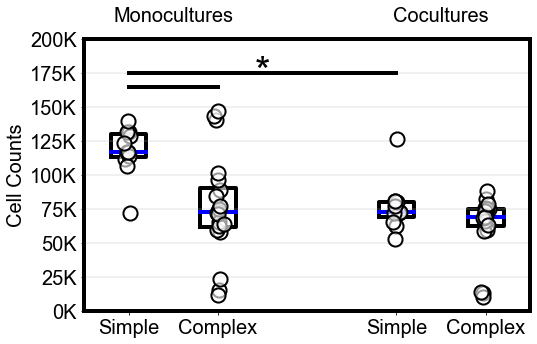

In [482]:
fig,ax = plt.subplots(figsize=[8,5])

kwargs_scatter = {'s':200,'lw':2,'edgecolor':'black','color':(1,1,1,0.6),'zorder':3}
kwargs_boxprops = {'lw':4,'color':'k','zorder':1}
kwargs_medianprops = {'lw':4,'color':'b','zorder':2}
kwargs_whiskerprops = {'lw':0}

ax.boxplot(d2_mono,positions=[0],widths=0.4,showfliers=False,showcaps=False,
           boxprops=kwargs_boxprops,medianprops=kwargs_medianprops,whiskerprops=kwargs_whiskerprops)
ax.boxplot(d1_mono,positions=[1],widths=0.4,showfliers=False,showcaps=False,
           boxprops=kwargs_boxprops,medianprops=kwargs_medianprops,
           whiskerprops=kwargs_whiskerprops)

ax.boxplot(d2_co,positions=[3],widths=0.4,showfliers=False,showcaps=False,
           boxprops=kwargs_boxprops,medianprops=kwargs_medianprops,whiskerprops=kwargs_whiskerprops)
ax.boxplot(d1_co,positions=[4],widths=0.4,showfliers=False,showcaps=False,
           boxprops=kwargs_boxprops,medianprops=kwargs_medianprops,
           whiskerprops=kwargs_whiskerprops)

ax.scatter(np.random.normal(0,0.025,len(d2_mono)),d2_mono,**kwargs_scatter)
ax.scatter(np.random.normal(1,0.025,len(d1_mono)),d1_mono,**kwargs_scatter)

ax.scatter(np.random.normal(3,0.025,len(d2_co)),d2_co,**kwargs_scatter)
ax.scatter(np.random.normal(4,0.025,len(d1_co)),d1_co,**kwargs_scatter)


thicken_spines(ax,lw=4)
largeTickLabels(ax,20)

plt.setp(ax,xticks=[0,1,3,4],xticklabels=['Simple','Complex','Simple','Complex'])

ax.yaxis.grid(lw=1.5,alpha=0.25)
ax.yaxis.set_major_formatter(FuncFormatter(reformat_thousands_ticks))
ax.yaxis.set_major_locator(MultipleLocator(25000))
ax.set_ylim([0,200000])
ax.set_xlim([-0.5,4.5])


ax.set_ylabel('Cell Counts',fontsize=20)
ax.text(1/5,1.05,'Monocultures',transform=ax.transAxes,ha='center',va='bottom',fontsize=20)
ax.text(4/5,1.05,'Cocultures',transform=ax.transAxes,ha='center',va='bottom',fontsize=20)

ax.axhline(165000,0.1,0.3,lw=4,color='k')

ax.axhline(175000,0.1,0.7,lw=4,color='k')
ax.text(1.5,175000,'*',ha='center',va='center',fontsize=40)

plt.savefig(ParentPath + '/figures/boxplots_max_counts_by_substrate_type.pdf',bbox_inches='tight')

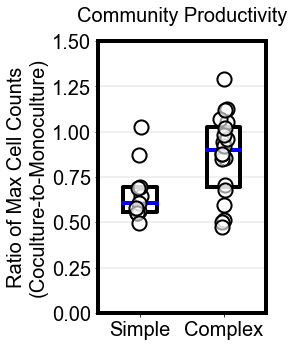

In [557]:
fig,ax = plt.subplots(figsize=[3,5])

kwargs_scatter = {'s':200,'lw':2,'edgecolor':'black','color':(1,1,1,0.6),'zorder':3}
kwargs_boxprops = {'lw':4,'color':'k','zorder':2}
kwargs_medianprops = {'lw':4,'color':'b'}
kwargs_whiskerprops = {'lw':0}
kwargs_capprops = {'lw':0}

d1 = subsetDf(max_counts_joined,{'Substrate_Group':'Simple Sugars'})
d1 = d1.Ratio.values

d2 = subsetDf(max_counts_joined,{'Substrate_Group':'Complex Sugars'})
d2 = d2.Ratio.values

ax.boxplot(d1,positions=[0],widths=0.4,showfliers=False,showcaps=False,
           boxprops=kwargs_boxprops,medianprops=kwargs_medianprops,
           whiskerprops=kwargs_whiskerprops)
ax.boxplot(d2,positions=[1],widths=0.4,showfliers=False,showcaps=False,
           boxprops=kwargs_boxprops,medianprops=kwargs_medianprops,
           whiskerprops=kwargs_whiskerprops)

ax.scatter(np.random.normal(0,0.025,len(d1)),d1,**kwargs_scatter)
ax.scatter(np.random.normal(1,0.025,len(d2)),d2,**kwargs_scatter)

thicken_spines(ax,lw=4)
largeTickLabels(ax,20)

plt.setp(ax,xticklabels=['Simple','Complex'])

ax.yaxis.grid(lw=1.5,alpha=0.25)
ax.yaxis.set_major_locator(MultipleLocator(0.25))
ax.set_ylim([0,1.5])
ax.set_xlim([-0.5,1.5])


ax.set_ylabel('Ratio of Max Cell Counts\n(Coculture-to-Monoculture)',fontsize=20)
ax.set_title('Community Productivity',fontsize=20,y=1.05)

plt.savefig(ParentPath + '/figures/boxplots_productivity_ratio.pdf',bbox_inches='tight')

In [538]:
print(wilcoxon(d1-1,alternative="two-sided"))
print(wilcoxon(d2-1,alternative="two-sided"))

WilcoxonResult(statistic=1.0, pvalue=0.001953125)
WilcoxonResult(statistic=45.0, pvalue=0.023950576782226562)


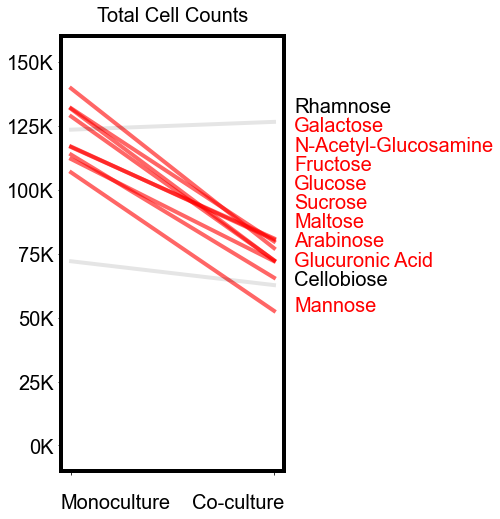

In [499]:
toplot = max_counts_joined[max_counts_joined.Substrate_Group=='Simple Sugars'].sort_values(['Ratio'])

fig,ax = plt.subplots(figsize=[4,8])

annotations = []
for idx, row in toplot.iterrows():
    
    monov = row['MaxCountMono']
    cov = row['MaxCountCo']
    
    if (cov/monov) > 1.2 :
        color = 'blue'
        lw = 4
        alpha = 0.6
        
        annotations.append([idx,color,cov])
    elif (cov/monov) < 0.8:
        color = 'red'
        lw = 4
        alpha = 0.6
        
        
    else:
        color = 'black'
        lw = 4
        alpha = 0.1
        
    #print(monov,cov,cov/monov,color,lw)
        
    ax.plot([0,1],[monov,cov],color=color,alpha=alpha,lw=lw)
    annotations.append([idx,color,cov])   
    
annotations = pd.DataFrame(annotations,columns=['Substrate','Color','Y'])
annotations = annotations.sort_values(['Y'])
annotations_copy = annotations.copy()

y_values = annotations_copy.Y.values
for ii in range(annotations_copy.shape[0]-1):
    while y_values[ii+1] - y_values[ii] < 7500: y_values[ii+1] = y_values[ii] + 7500
annotations_copy.loc[:,'Y'] = y_values
  

for idx,row in annotations_copy.iterrows():
    
    ax.text(1.1,row['Y'],dict_substrate_label[row['Substrate']],color=row['Color'],  fontsize=20)
    
            
thicken_spines(ax,lw=4)
largeTickLabels(ax)

ax.yaxis.set_major_formatter(FuncFormatter(reformat_thousands_ticks))
ax.yaxis.set_major_locator(MultipleLocator(25000))
ax.set_ylim([-10000,160000])

plt.setp(ax,xticks=[0,1],xticklabels=['',''])

ax.text(0,-0.05,'Monoculture',fontsize=20,ha='left',va='top',transform=ax.transAxes)
ax.text(1,-0.05,'Co-culture',fontsize=20,ha='right',va='top',transform=ax.transAxes)
ax.set_title('Total Cell Counts',fontsize=20,y=1.02)

plt.savefig(ParentPath + '/figures/change_productivity_simple.pdf',bbox_inches='tight')

Text(0.5, 1.02, 'Total Cell Counts')

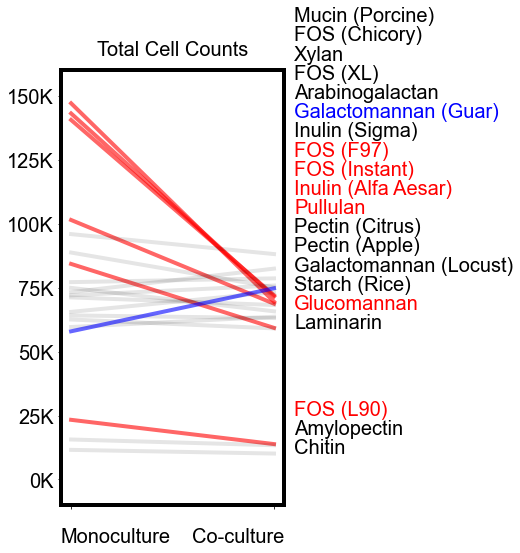

In [500]:
toplot = max_counts_joined[max_counts_joined.Substrate_Group=='Complex Sugars'].sort_values(['Ratio'])

fig,ax = plt.subplots(figsize=[4,8])

annotations = []
for idx, row in toplot.iterrows():
    
    monov = row['MaxCountMono']
    cov = row['MaxCountCo']
    
    if (cov/monov) > 1.2 :
        color = 'blue'
        lw = 4
        alpha = 0.6
    elif (cov/monov) < 0.8:
        color = 'red'
        lw = 4
        alpha = 0.6
    else:
        color = 'black'
        lw = 4
        alpha = 0.1
        
    #print(monov,cov,cov/monov,color,lw)
        
    ax.plot([0,1],[monov,cov],color=color,alpha=alpha,lw=lw)
        
    annotations.append([idx,color,cov])
    
    
    
annotations = pd.DataFrame(annotations,columns=['Substrate','Color','Y'])
annotations = annotations.sort_values(['Y'])
annotations_copy = annotations.copy()

y_values = annotations_copy.Y.values
for ii in range(annotations_copy.shape[0]-1):
    while y_values[ii+1] - y_values[ii] < 7500: y_values[ii+1] = y_values[ii] + 7500
annotations_copy.loc[:,'Y'] = y_values
  

for idx,row in annotations_copy.iterrows():
    
    ax.text(1.1,row['Y'],dict_substrate_label[row['Substrate']],color=row['Color'],  fontsize=20)
    
            
thicken_spines(ax,lw=4)
largeTickLabels(ax)

ax.yaxis.set_major_formatter(FuncFormatter(reformat_thousands_ticks))
ax.yaxis.set_major_locator(MultipleLocator(25000))
ax.set_ylim([-10000,160000])

plt.setp(ax,xticks=[0,1],xticklabels=['',''])

ax.text(0,-0.05,'Monoculture',fontsize=20,ha='left',va='top',transform=ax.transAxes)
ax.text(1,-0.05,'Co-culture',fontsize=20,ha='right',va='top',transform=ax.transAxes)
ax.set_title('Total Cell Counts',fontsize=20,y=1.02)

#plt.savefig(ParentPath + '/figures/change_productivity_complex.pdf',bbox_inches='tight')

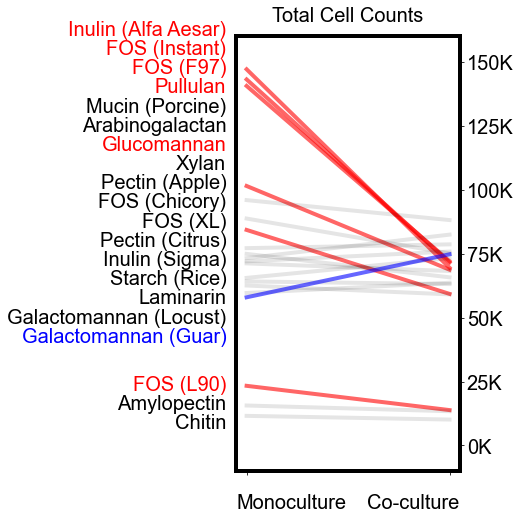

In [587]:
toplot = max_counts_joined[max_counts_joined.Substrate_Group=='Complex Sugars'].sort_values(['Ratio'])

fig,ax = plt.subplots(figsize=[4,8])
ax.yaxis.tick_right()

annotations = []
for idx, row in toplot.iterrows():
    
    monov = row['MaxCountMono']
    cov = row['MaxCountCo']
    
    if (cov/monov) > 1.2 :
        color = 'blue'
        lw = 4
        alpha = 0.6
    elif (cov/monov) < 0.8:
        color = 'red'
        lw = 4
        alpha = 0.6
    else:
        color = 'black'
        lw = 4
        alpha = 0.1
        
    #print(monov,cov,cov/monov,color,lw)
        
    ax.plot([0,1],[monov,cov],color=color,alpha=alpha,lw=lw)
        
    annotations.append([idx,color,monov])
    
annotations = pd.DataFrame(annotations,columns=['Substrate','Color','Y'])
annotations = annotations.sort_values(['Y'])
annotations_copy = annotations.copy()

y_values = annotations_copy.Y.values
for ii in range(annotations_copy.shape[0]-1):
    while y_values[ii+1] - y_values[ii] < 7500: y_values[ii+1] = y_values[ii] + 7500
annotations_copy.loc[:,'Y'] = y_values
  

for idx,row in annotations_copy.iterrows():
    y_pos = row['Y']
    if y_pos > 50000: 
        y_pos -= 17500
    else:
        y_pos -= 5000
    ax.text(-0.1,y_pos,dict_substrate_label[row['Substrate']],color=row['Color'],  fontsize=20,ha='right')
    
            
thicken_spines(ax,lw=4)
largeTickLabels(ax)

ax.yaxis.set_major_formatter(FuncFormatter(reformat_thousands_ticks))
ax.yaxis.set_major_locator(MultipleLocator(25000))
ax.set_ylim([-10000,160000])

plt.setp(ax,xticks=[0,1],xticklabels=['',''])

ax.text(0,-0.05,'Monoculture',fontsize=20,ha='left',va='top',transform=ax.transAxes)
ax.text(1,-0.05,'Co-culture',fontsize=20,ha='right',va='top',transform=ax.transAxes)
ax.set_title('Total Cell Counts',fontsize=20,y=1.02)

plt.savefig(ParentPath + '/figures/change_productivity_complex.pdf',bbox_inches='tight')

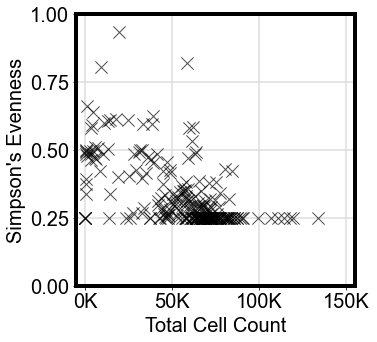

In [493]:
fig,ax = plt.subplots(figsize=[5,5])

scatter_kw = {'s':150,'lw':1.0,'color':(0,0,0,0.7),'marker':'x','zorder':2}

ax.scatter(df_results_filtered.CorrectedMixedCount,df_results_filtered.SimpsonEvenness,**scatter_kw)

ax.set_ylim([0,1])
ax.set_xlim([-5000,155000])

ax.xaxis.set_major_formatter(FuncFormatter(reformat_thousands_ticks))
ax.xaxis.set_major_locator(MultipleLocator(50000))
ax.yaxis.set_major_locator(MultipleLocator(0.25))

largeTickLabels(ax,fontsize=20)
thicken_spines(ax,lw=4)

grid_kw = {'which':'Major','color':'#DDDDDD','lw':1.5,'ls':'-','zorder':1}
ax.xaxis.grid(**grid_kw)
ax.yaxis.grid(**grid_kw)

ax.set_xlabel('Total Cell Count',fontsize=20)
ax.set_ylabel("Simpson's Evenness",fontsize=20)

plt.savefig(ParentPath + '/figures/productivity_vs_diversity.pdf',bbox_inches='tight')

In [515]:
max_counts_mono = []
max_counts_co = []
for sp in ['BO','BF','BT','BV']:
    
    toplot = df_results_median.loc[:,['Substrate','TimePoint','CorrectedMonoCount_'+sp]]
    toplot = toplot.pivot(index='Substrate',columns=['TimePoint'],values='CorrectedMonoCount_'+sp)
    max_counts_mono.append(toplot.max(1))

    toplot = df_results_median.loc[:,['Substrate','TimePoint','MixedRelAbund_'+sp,'CorrectedMixedCount']]
    toplot.loc[:,'MixedAbsAbund_'+sp] = toplot.apply(lambda x: x['MixedRelAbund_'+sp] * x['CorrectedMixedCount'],axis=1).values
    toplot = toplot.pivot(index='Substrate',columns=['TimePoint'],values='MixedAbsAbund_'+sp)
    max_counts_co.append(toplot.max(1)) 

max_counts_mono = pd.concat(max_counts_mono,axis=1)
max_counts_mono.columns = ['BO','BF','BT','BV']

max_counts_co = pd.concat(max_counts_co,axis=1)
max_counts_co.columns = ['BO','BF','BT','BV']

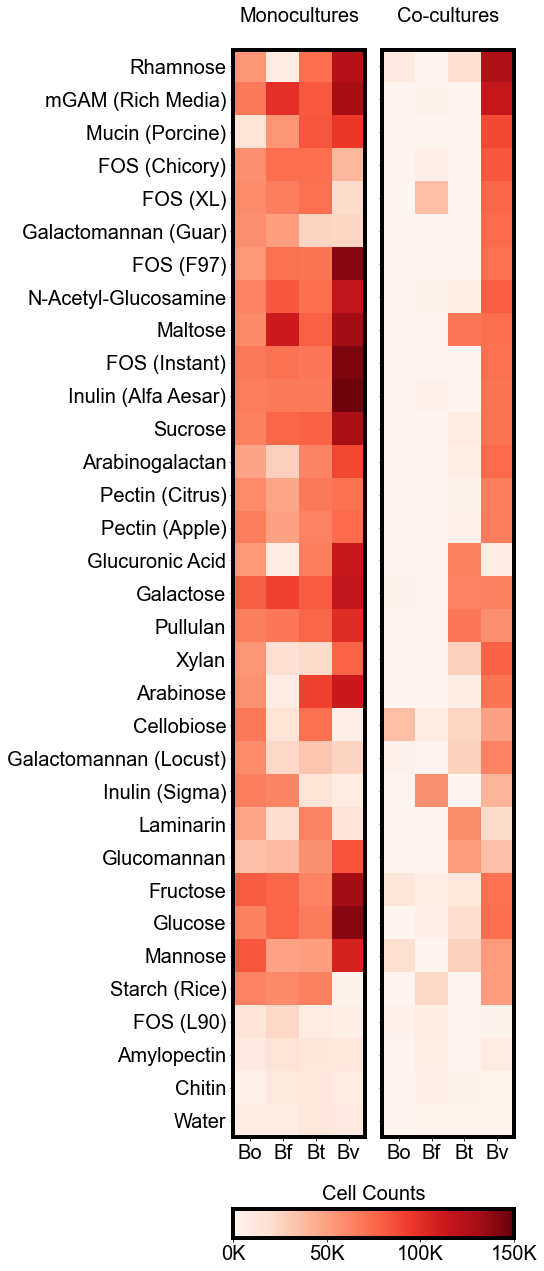

In [519]:
fig,axes = plt.subplots(1,2,figsize=[8,20],sharey=False)

vmin = 0
vmax = 150000
vint = 50000

axl=axes[0]
hl = axl.imshow(max_counts_mono.loc[substrate_order[::-1],:],cmap='Reds',vmin=vmin,vmax=vmax)
subtrate_labels = [dict_substrate_label[ii] for ii in substrate_order[::-1]]
plt.setp(axl,yticks=range(len(substrate_order)),yticklabels=subtrate_labels);
axl.set_title('Monocultures',fontsize=20,y=1.02)

axr=axes[1]
hr = axr.imshow(max_counts_co.loc[substrate_order[::-1],:],cmap='Reds',vmin=vmin,vmax=vmax)
plt.setp(axr,yticks=range(len(substrate_order)),yticklabels=[]);
axr.set_title('Co-cultures',fontsize=20,y=1.02)

for ax in axes:
    largeTickLabels(ax)
    thicken_spines(ax,lw=4)
    plt.setp(ax,xticks=[0,1,2,3],xticklabels=['Bo','Bf','Bt','Bv'])

plt.subplots_adjust(wspace=-0.5)

cb_offset = 0.07
cb_height = 0.02
cbar_ax = fig.add_axes([axl.get_position().x0,axl.get_position().y0-cb_offset,
                        axr.get_position().x1-axl.get_position().x0,cb_height])
fig.colorbar(hl,cax=cbar_ax,orientation='horizontal')

largeTickLabels(cbar_ax)
thicken_spines(cbar_ax,lw=4)
cbar_ax.xaxis.set_major_formatter(FuncFormatter(reformat_thousands_ticks))
cbar_ax.set_xlim([0,vmax])
cbar_ax.xaxis.set_major_locator(MultipleLocator(vint))
cbar_ax.set_title('Cell Counts',fontsize=20,y=1.1)

plt.savefig(ParentPath + '/figures/heatmaps_maximum_cell_counts.pdf',bbox_inches='tight')

**compare max grwoth on simple and complex sugar per species
2022-01-28**

In [522]:
varbs = ['Substrate','TimePoint']
varbs+= ['CorrectedMonoCount_'+ii for ii in ['BO','BF','BT','BV']]
                                   
max_counts = df_results_median
max_counts.Substrate = max_counts.Substrate.replace({'Cellibiose':'Cellobiose'})
max_counts = max_counts.loc[:,varbs]
max_counts.columns = ['Substrate','TimePoint','BO','BF','BT','BV']
#max_counts = max_counts.set_index(['Substrate','TimePoint']).max(1).reset_index()
max_counts

arr_max_counts_species = []

for sp in ['BO','BF','BT','BV']:
    max_counts_species = max_counts.loc[:,['Substrate','TimePoint',sp]]
    max_counts_species = max_counts_species.pivot(index='Substrate',columns='TimePoint',values=sp).max(1)
    arr_max_counts_species.append(pd.DataFrame(max_counts_species,columns=[sp]))
    
max_counts_species = pd.concat(arr_max_counts_species,axis=1).join(substrate_descriptions)
max_counts_species.to_csv(ParentPath + '/tables/max_counts_species_substrates.txt',sep='\t',header=True,index=True)
max_counts_species.head()

,BO,BF,BT,BV,Substrate_Label,Substrate_Type,Substrate_Group
Substrate,,,,,,,
Amylopectin,9896.5,15626.0,13231.5,11168.5,Amylopectin,Polysaccharide,Complex Sugars
Arabinogalactan,47679.5,26520.5,62676.0,88710.5,Arabinogalactan,Polysaccharide,Complex Sugars
Arabinose,56774.0,7484.5,90899.5,111965.0,Arabinose,Monosaccharide,Simple Sugars
Cellobiose,67683.5,15749.5,72016.0,4661.0,Cellobiose,Disaccharide,Simple Sugars
Chitin,2998.0,10828.0,11576.0,7723.0,Chitin,Polysaccharide,Complex Sugars


In [523]:
max_counts_species_means = max_counts_species.groupby('Substrate_Group').mean()
max_counts_species_means

,BO,BF,BT,BV
Substrate_Group,,,,
Complex Sugars,48394.725000,45776.825000,50712.200000,59167.475000
Rich Media,68472.000000,100014.500000,81972.750000,129609.500000
Simple Sugars,66107.136364,54466.409091,71750.136364,111418.590909
Water,6446.000000,6737.000000,11445.750000,9984.500000


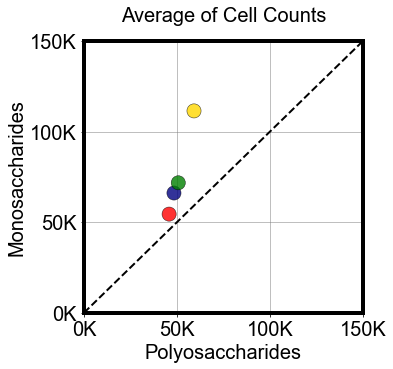

In [525]:
fig,ax = plt.subplots(figsize=[5,5])

## my isolates

x = max_counts_species_means.loc['Complex Sugars',:].values
y = max_counts_species_means.loc['Simple Sugars',:].values

c = ['navy','red','green','gold']

ax.scatter(x,y,s=200,marker='o',color=c,alpha=0.8,lw=0.5,edgecolor='black',zorder=4)

ax.set_xlim([0,150000])
ax.set_ylim([0,150000])

ax.plot([0,150000],[0,150000],ls='--',lw=2,color='black')

ax.xaxis.set_major_locator(MultipleLocator(50000))
ax.yaxis.set_major_locator(MultipleLocator(50000))

ax.xaxis.set_major_formatter(FuncFormatter(reformat_thousands_ticks))
ax.yaxis.set_major_formatter(FuncFormatter(reformat_thousands_ticks))


largeTickLabels(ax)
thicken_spines(ax)

ax.set_title('Average of Cell Counts',fontsize=20,y=1.05)

ax.set_xlabel('Polyosaccharides',fontsize=20)
ax.set_ylabel('Monosaccharides',fontsize=20)

ax.xaxis.grid(which="major",lw=0.5,color='gray',zorder=1)
ax.yaxis.grid(which="major",lw=0.5,color='gray',zorder=1)

plt.savefig(ParentPath + '/figures/comparison_pudlo_2021_scatter_a.pdf',bbox_inches='tight')